In [1]:
import sys, os
sys.path.insert(0,"/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/")


In [2]:
from pathflowai.utils import load_sql_df

nonechucks may not work properly with this version of PyTorch (1.6.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [3]:
df=load_sql_df("complete/patch_info_new_final.db",128)

In [4]:
from sklearn.neighbors import NearestNeighbors
graphs=df.groupby(['ID'])[["x","y"]].apply(lambda x: NearestNeighbors(radius=128,n_jobs=25).fit(x.values).radius_neighbors_graph(x.values))

In [5]:
df['annotation'].unique()

array(['Complete', 'Incomplete_Section', 'Incomplete_Area'], dtype=object)

In [6]:
import scipy.sparse as sps
components=graphs.apply(lambda x: sps.csgraph.connected_components(x)[1])

In [7]:
from collections import Counter

In [8]:
import pandas as pd
df['y_true']=df['annotation'].apply(lambda x: "Incomplete" in x)#Incomplete_Area
point_clouds=[]
for name,dff in df.groupby(['ID']):
    xy=dff[["x","y",'y_true']]
    xy['components']=components.loc[name]
    for name2, xy2 in xy.groupby('components'):
        if xy2.shape[0]>300:
            point_clouds.append((name,name2,(xy2['y_true']>0).mean()>0,xy2[['x','y']].values))
            
point_clouds=pd.DataFrame(point_clouds,columns=['slide','component','incomplete','points'])

/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
len(point_clouds)

194

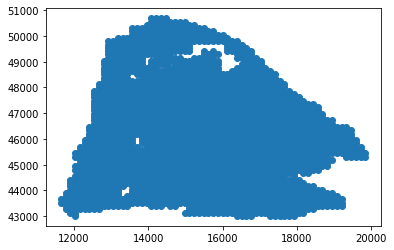

In [10]:
import matplotlib
matplotlib.rcParams['figure.dpi']=300
import matplotlib.pyplot as plt
plt.scatter(*point_clouds['points'][30].T.tolist())

In [11]:
import subprocess, os


In [12]:
import torch_scatter

In [13]:
from gtda.diagrams import PersistenceEntropy, PersistenceImage

import numpy as np

from gtda.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from gtda.plotting import plot_diagram, plot_point_cloud, plot_heatmap

In [14]:
point_clouds['incomplete'].mean()

0.23711340206185566

In [113]:
n_clouds=point_clouds.shape[0]
X=point_clouds['points'].tolist()[:n_clouds]

In [114]:
from torch_sparse import coalesce, SparseTensor

In [115]:
import torch
from torch_geometric.nn import fps
X_new=[]
for i in range(len(X)):
#     print(i)
    tmp=torch.tensor(X[i]).float().cuda()
    res=fps(tmp,ratio=0.3)
    X_new.append(X[i][res.cpu().numpy()])
    del res, tmp


In [116]:
from gtda.homology._utils import _postprocess_diagrams
import dask, dask.diagnostics
from gtda.homology import VietorisRipsPersistence


In [117]:
homology_dimensions = (0, 1)
def fit_persistence(x):
    VR = VietorisRipsPersistence(
        metric='euclidean', max_edge_length=3000, homology_dimensions=homology_dimensions, n_jobs=1).fit([x])
    return VR._ripser_diagram(x)

In [118]:
with dask.diagnostics.ProgressBar():
    diagrams=dask.compute(*[dask.delayed(fit_persistence)(x) for x in X_new],scheduler="processes")

[########################################] | 100% Completed | 59.9s


In [119]:
diagrams=_postprocess_diagrams(diagrams,(0,1),None,1)

In [120]:
plot_diagram(diagrams[0])


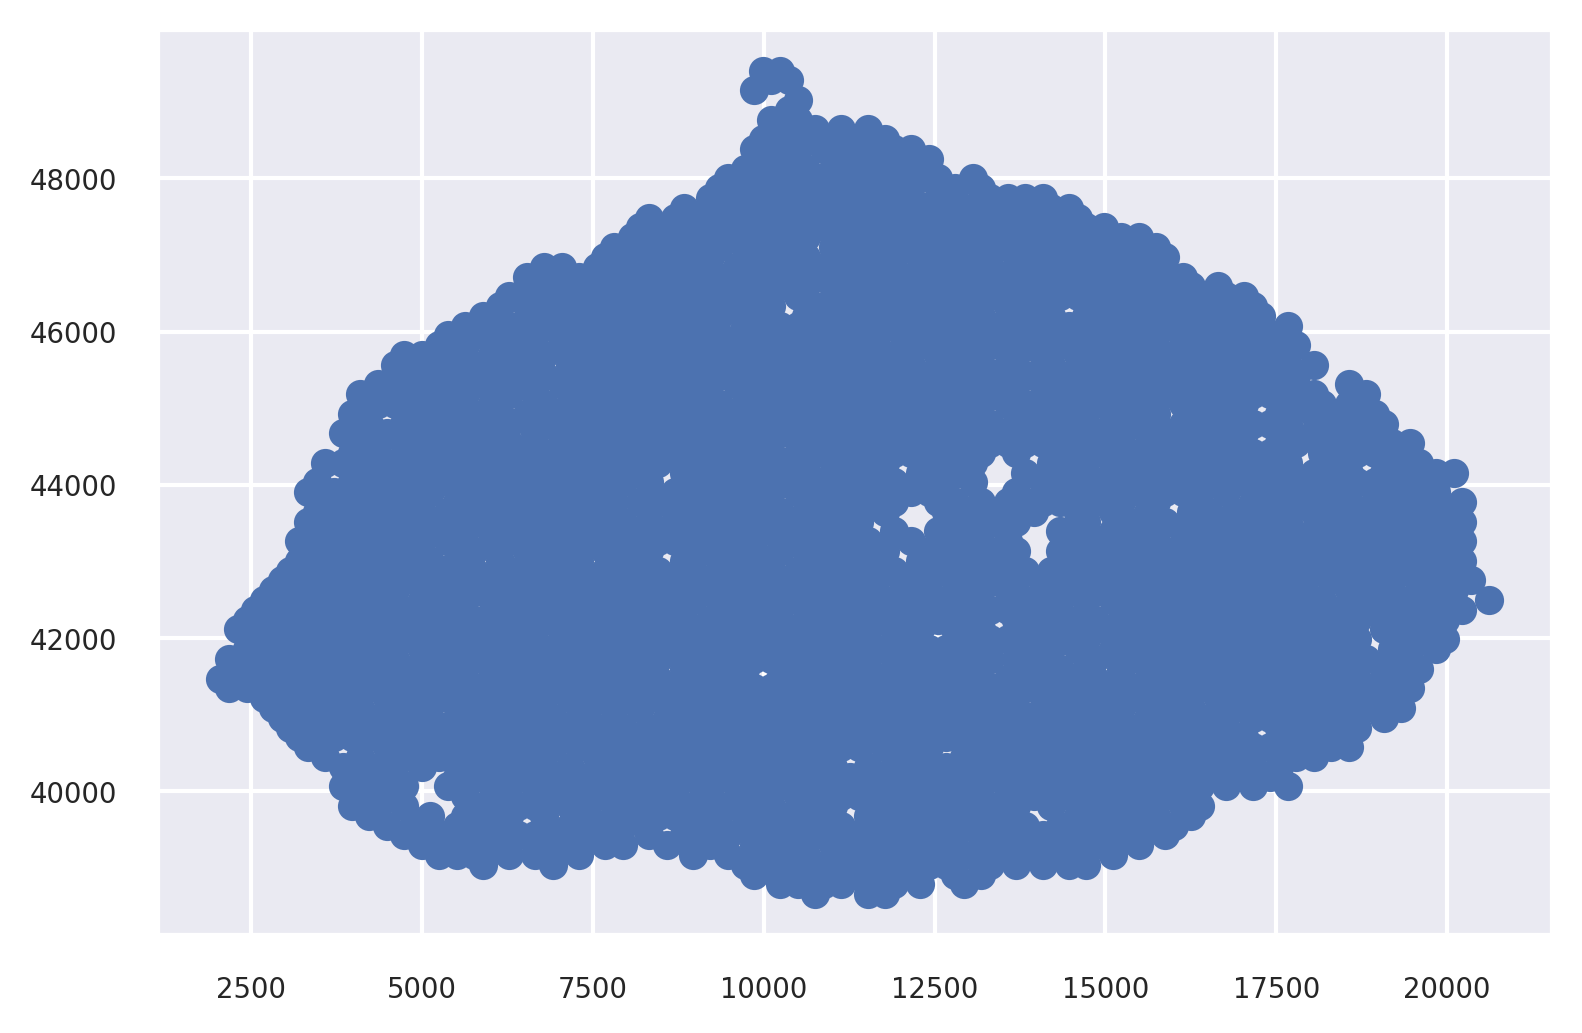

In [121]:
plt.scatter(*X_new[54].T.tolist())

In [122]:
diagrams[0].shape

(31082, 3)

In [123]:
diagrams[1].shape

(31082, 3)

In [124]:
diagrams[2].shape

(31082, 3)

In [125]:
PE = PersistenceImage()
X_train = PE.fit_transform(diagrams)

In [126]:
PE = PersistenceEntropy()
X_train0 = PE.fit_transform(diagrams)

/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning:

overflow encountered in reduce



In [127]:
X_train2=X_train.reshape(X_train.shape[0],-1)

In [128]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty="none",solver="saga",class_weight="balanced").fit(X_train0,point_clouds['incomplete'].astype(int).values[:n_clouds]).score(X_train0,point_clouds['incomplete'].astype(int).values[:n_clouds])

/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



0.6649484536082474

In [129]:
from sklearn.model_selection import cross_val_score,KFold

In [130]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
# sorted(sklearn.metrics.SCORERS.keys())

In [131]:
cross_val_score(LogisticRegression(class_weight="balanced"), X_train0, point_clouds['incomplete'].astype(int).values[:n_clouds], cv=10, n_jobs=1, scoring='roc_auc').mean()

0.48847619047619056

In [132]:
cross_val_score(LogisticRegression(class_weight="balanced"), X_train0, point_clouds['incomplete'].astype(int).values[:n_clouds], cv=10, n_jobs=1, scoring='f1_macro').mean()

0.39412365026051366

In [133]:
cross_val_score(RandomForestClassifier(class_weight="balanced"), X_train2, point_clouds['incomplete'].astype(int).values[:n_clouds], cv=10, n_jobs=1, scoring='roc_auc').mean()

0.3908571428571429

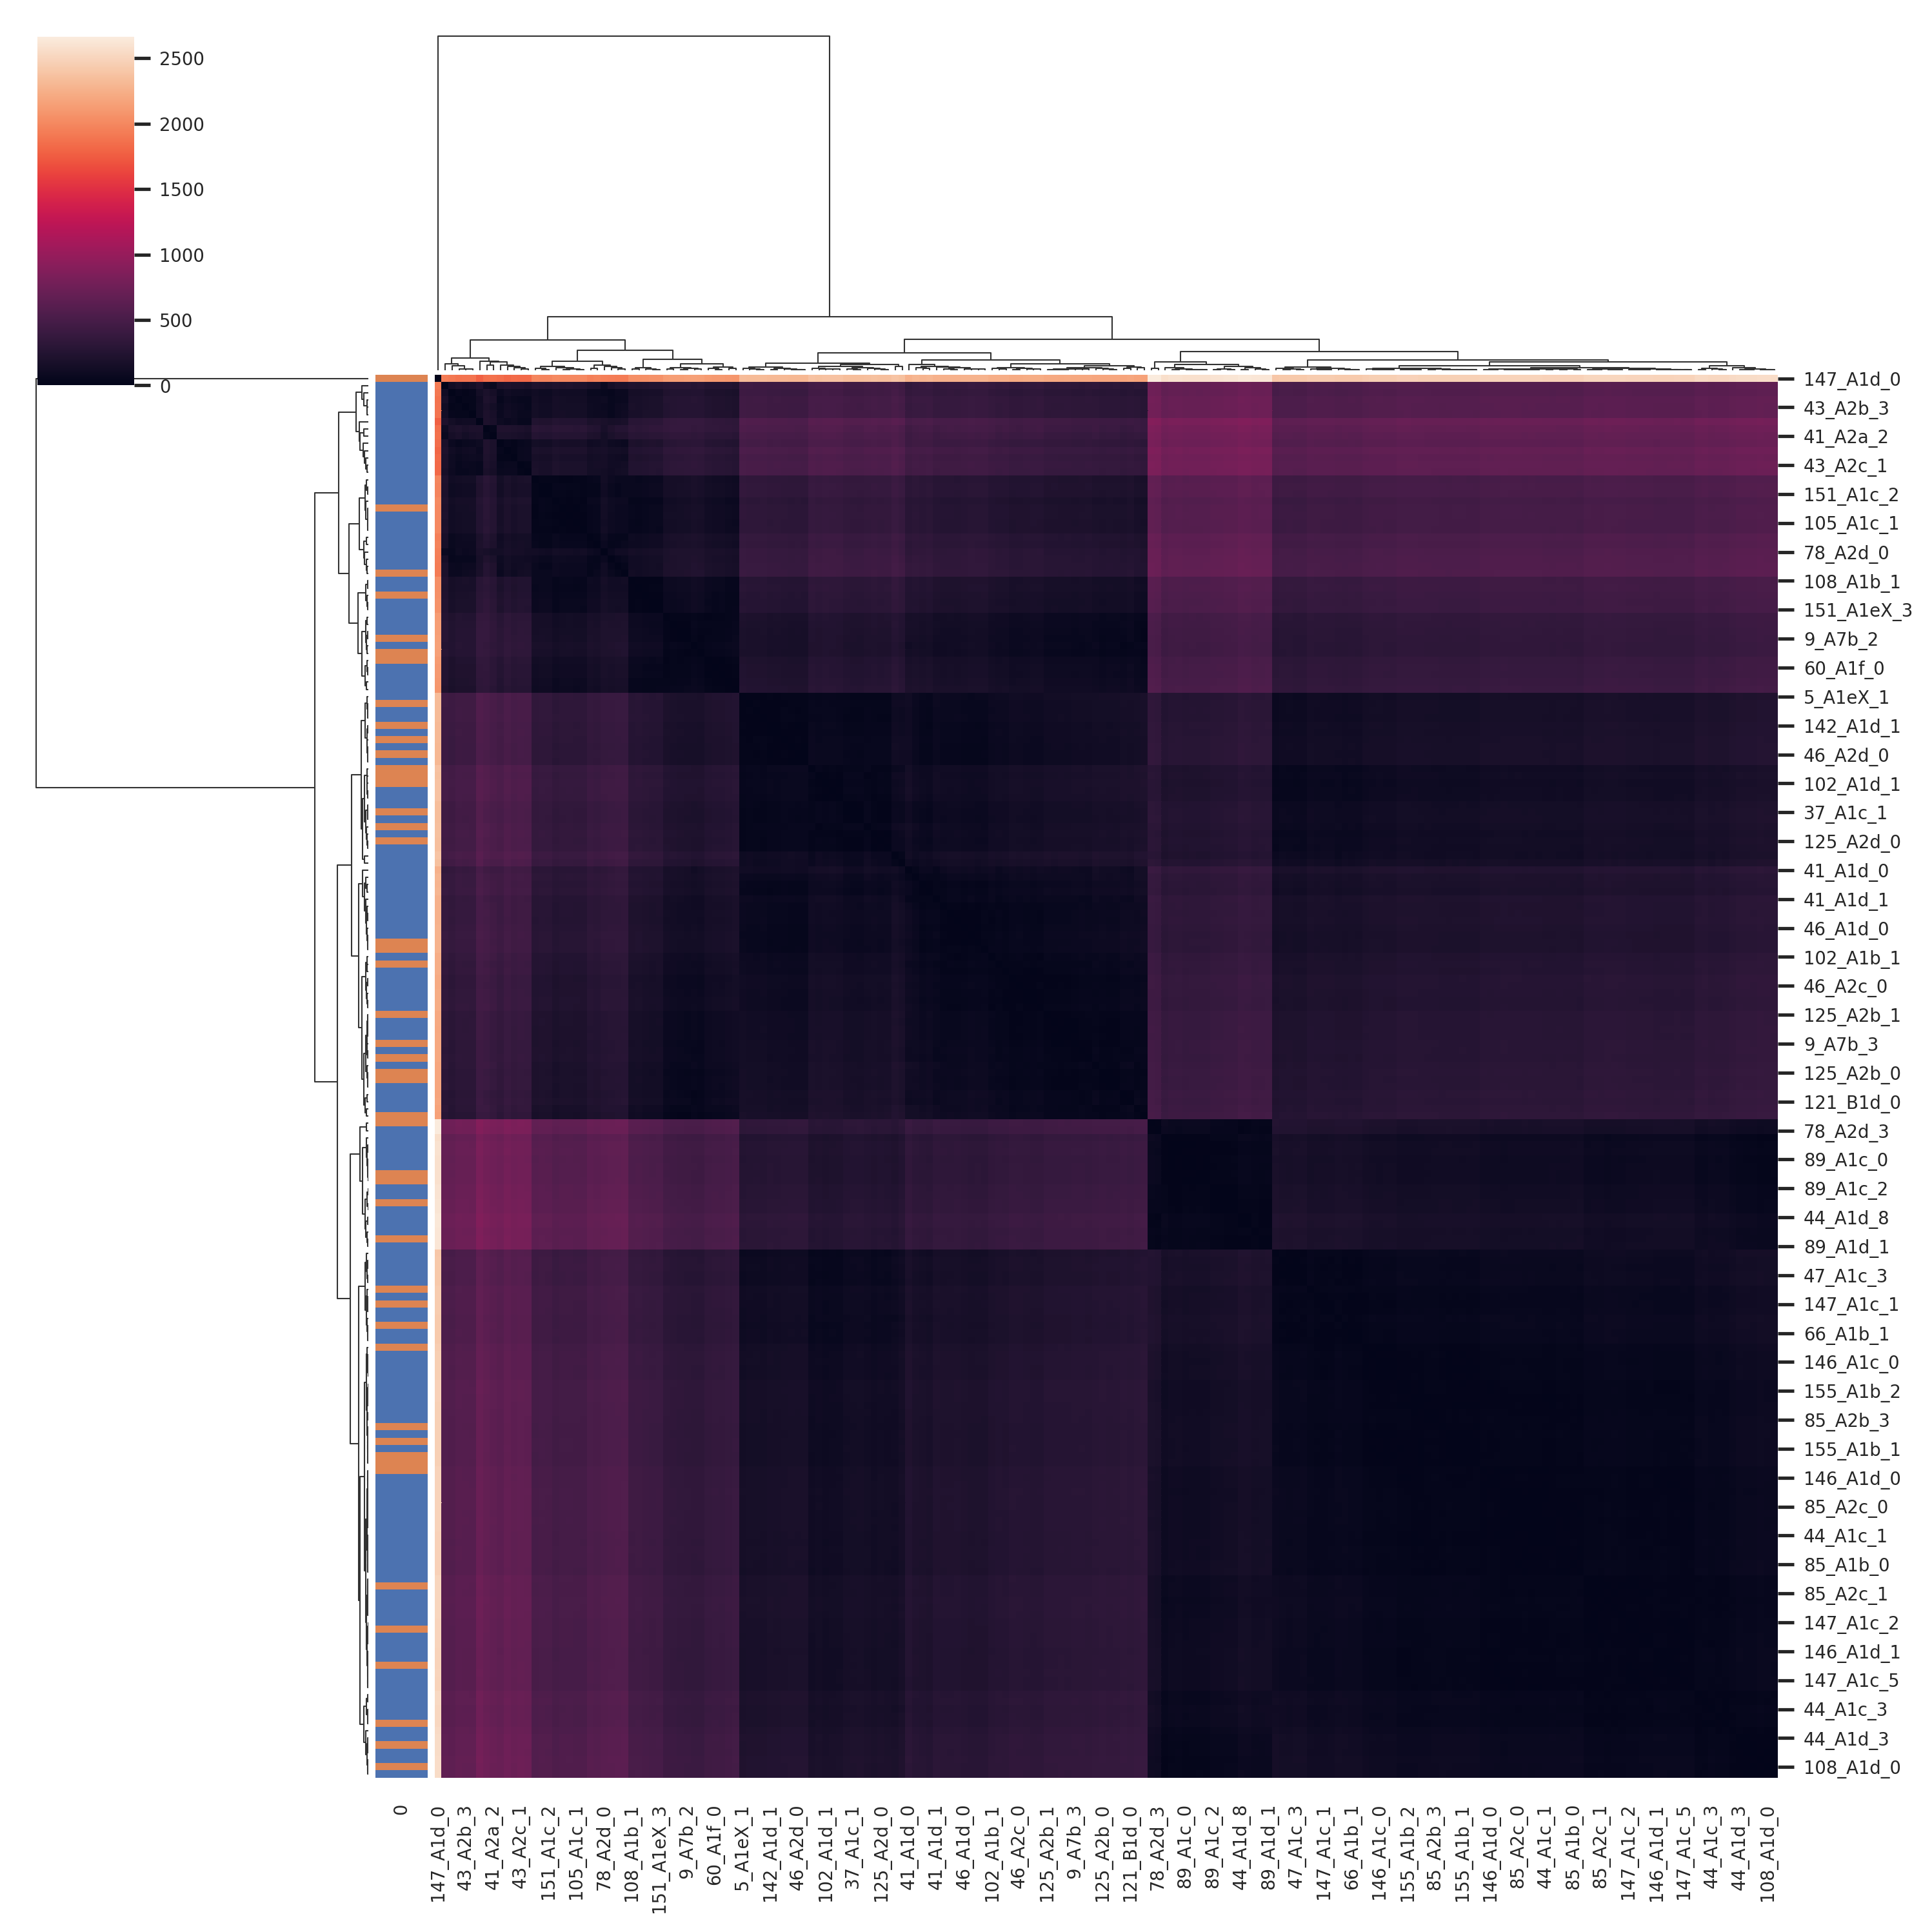

In [134]:
import seaborn as sns, pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi']=300
sns.set(font_scale=0.6)
from sklearn.metrics import pairwise_distances
ids=(point_clouds['slide']+"_"+point_clouds['component'].astype(str)).values[:n_clouds]
current_palette = sns.color_palette()
colors=pd.DataFrame(point_clouds['incomplete'].map(lambda x: current_palette[int(x)]).values[:n_clouds],index=ids)
sns.clustermap(pd.DataFrame(pairwise_distances(np.hstack([X_train0,X_train2])),columns=ids,index=ids),row_colors=colors)

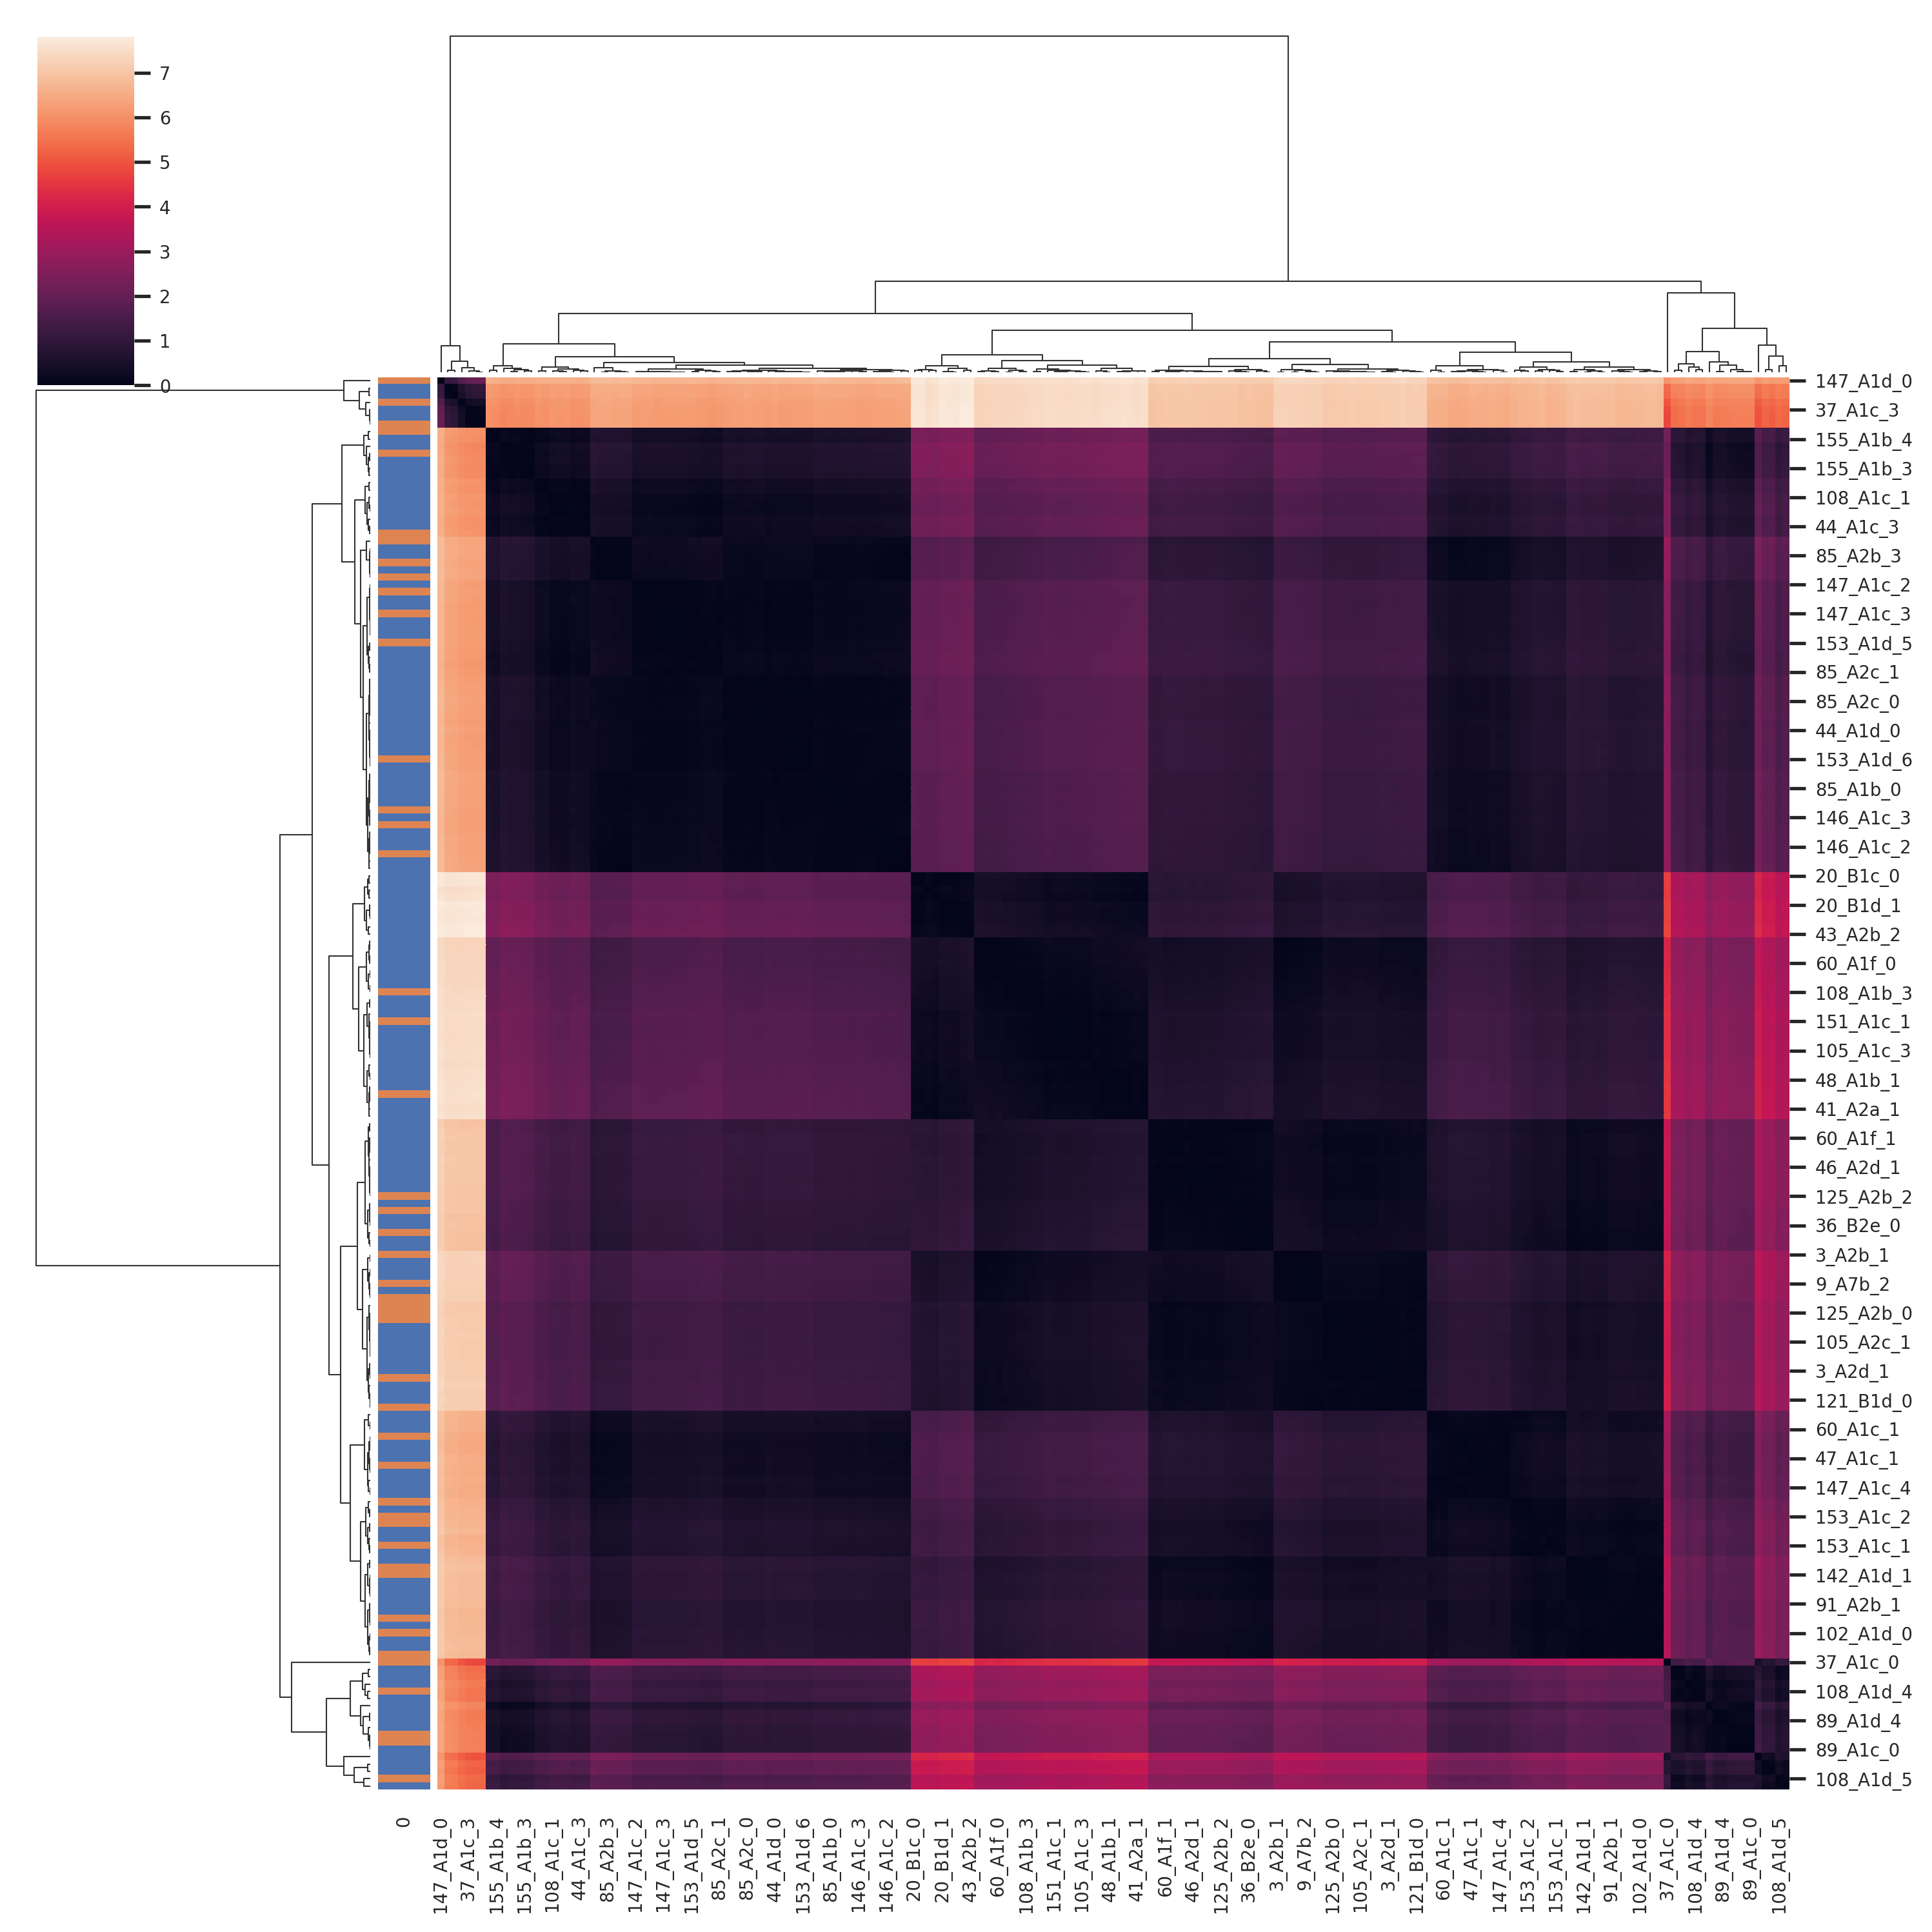

In [135]:
sns.clustermap(pd.DataFrame(pairwise_distances(X_train0),columns=ids,index=ids),row_colors=colors)

In [109]:
# plot_point_cloud(X_train0,3)


In [110]:
# Data wrangling
import numpy as np
import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module

# Data viz
from gtda.plotting import plot_point_cloud

# TDA magic
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)

# ML tools
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [111]:
filter_func = Projection(columns=[0, 1])
# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)
# Choose clustering algorithm - default is DBSCAN
clusterer = DBSCAN()

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

In [112]:
fig = plot_static_mapper_graph(pipe, X[0])
fig.show(config={'scrollZoom': True})

In [117]:
point_clouds['incomplete'].iloc[20:30]

20    False
21    False
22    False
23     True
24     True
25    False
26    False
27    False
28    False
29    False
Name: incomplete, dtype: bool

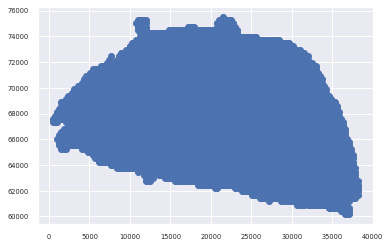

In [118]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(*X[23].T.tolist())

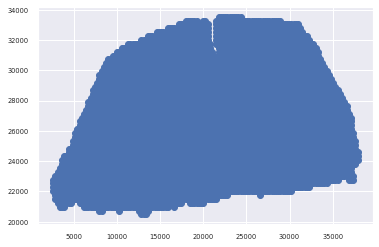

In [119]:
plt.scatter(*X[24].T.tolist())

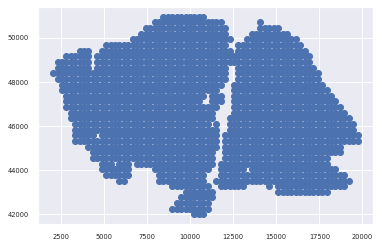

In [88]:
plt.scatter(*X[13].T.tolist())

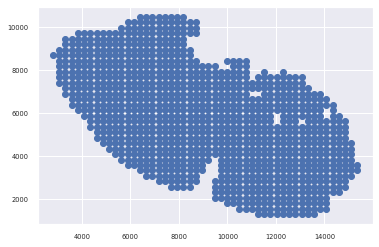

In [89]:
plt.scatter(*X[14].T.tolist())

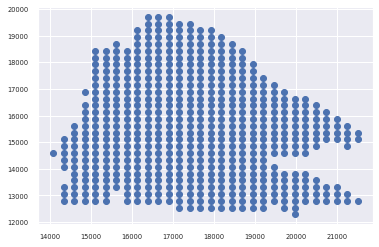

In [93]:
plt.scatter(*X[16].T.tolist())

In [120]:
fig = plot_static_mapper_graph(pipe, point_clouds['points'][24])
fig.show(config={'scrollZoom': True})

In [83]:
fig = plot_static_mapper_graph(pipe, point_clouds['points'][12])
fig.show(config={'scrollZoom': True})

In [84]:
fig = plot_static_mapper_graph(pipe, point_clouds['points'][13])
fig.show(config={'scrollZoom': True})

In [85]:
fig = plot_static_mapper_graph(pipe, point_clouds['points'][14])
fig.show(config={'scrollZoom': True})

In [79]:
fig = plot_static_mapper_graph(pipe, point_clouds['points'][205])
fig.show(config={'scrollZoom': True})

In [78]:
fig = plot_static_mapper_graph(pipe, point_clouds['points'][204])
fig.show(config={'scrollZoom': True})

In [2]:
import pickle
import numpy as np
import cv2
graph_datasets=pickle.load(open("bcc/graph_datasets/imagenet_graph_data_256_new.pkl",'rb'))

In [4]:
n_shapes=100
X=[x.pos.numpy() for x in graph_datasets['graph_dataset']][:n_shapes]#[:20]#graph_datasets['df'][graph_datasets['df']['ID']=="88_A1a"][['x','y']].values



In [5]:
len(X)

100

In [6]:
# ! python -m pip install -U giotto-tda


In [7]:
homology_dimensions = (0, 1, 2)
VR = VietorisRipsPersistence(
    metric='euclidean', max_edge_length=2500, homology_dimensions=homology_dimensions, n_jobs=25)

diagrams = VR.fit_transform(X)

/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [8]:
# diagrams

In [9]:
# for i in range(5,8):
plot_diagram(diagrams[1])


In [10]:
PE = PersistenceEntropy()
X_train = PE.fit_transform(diagrams)

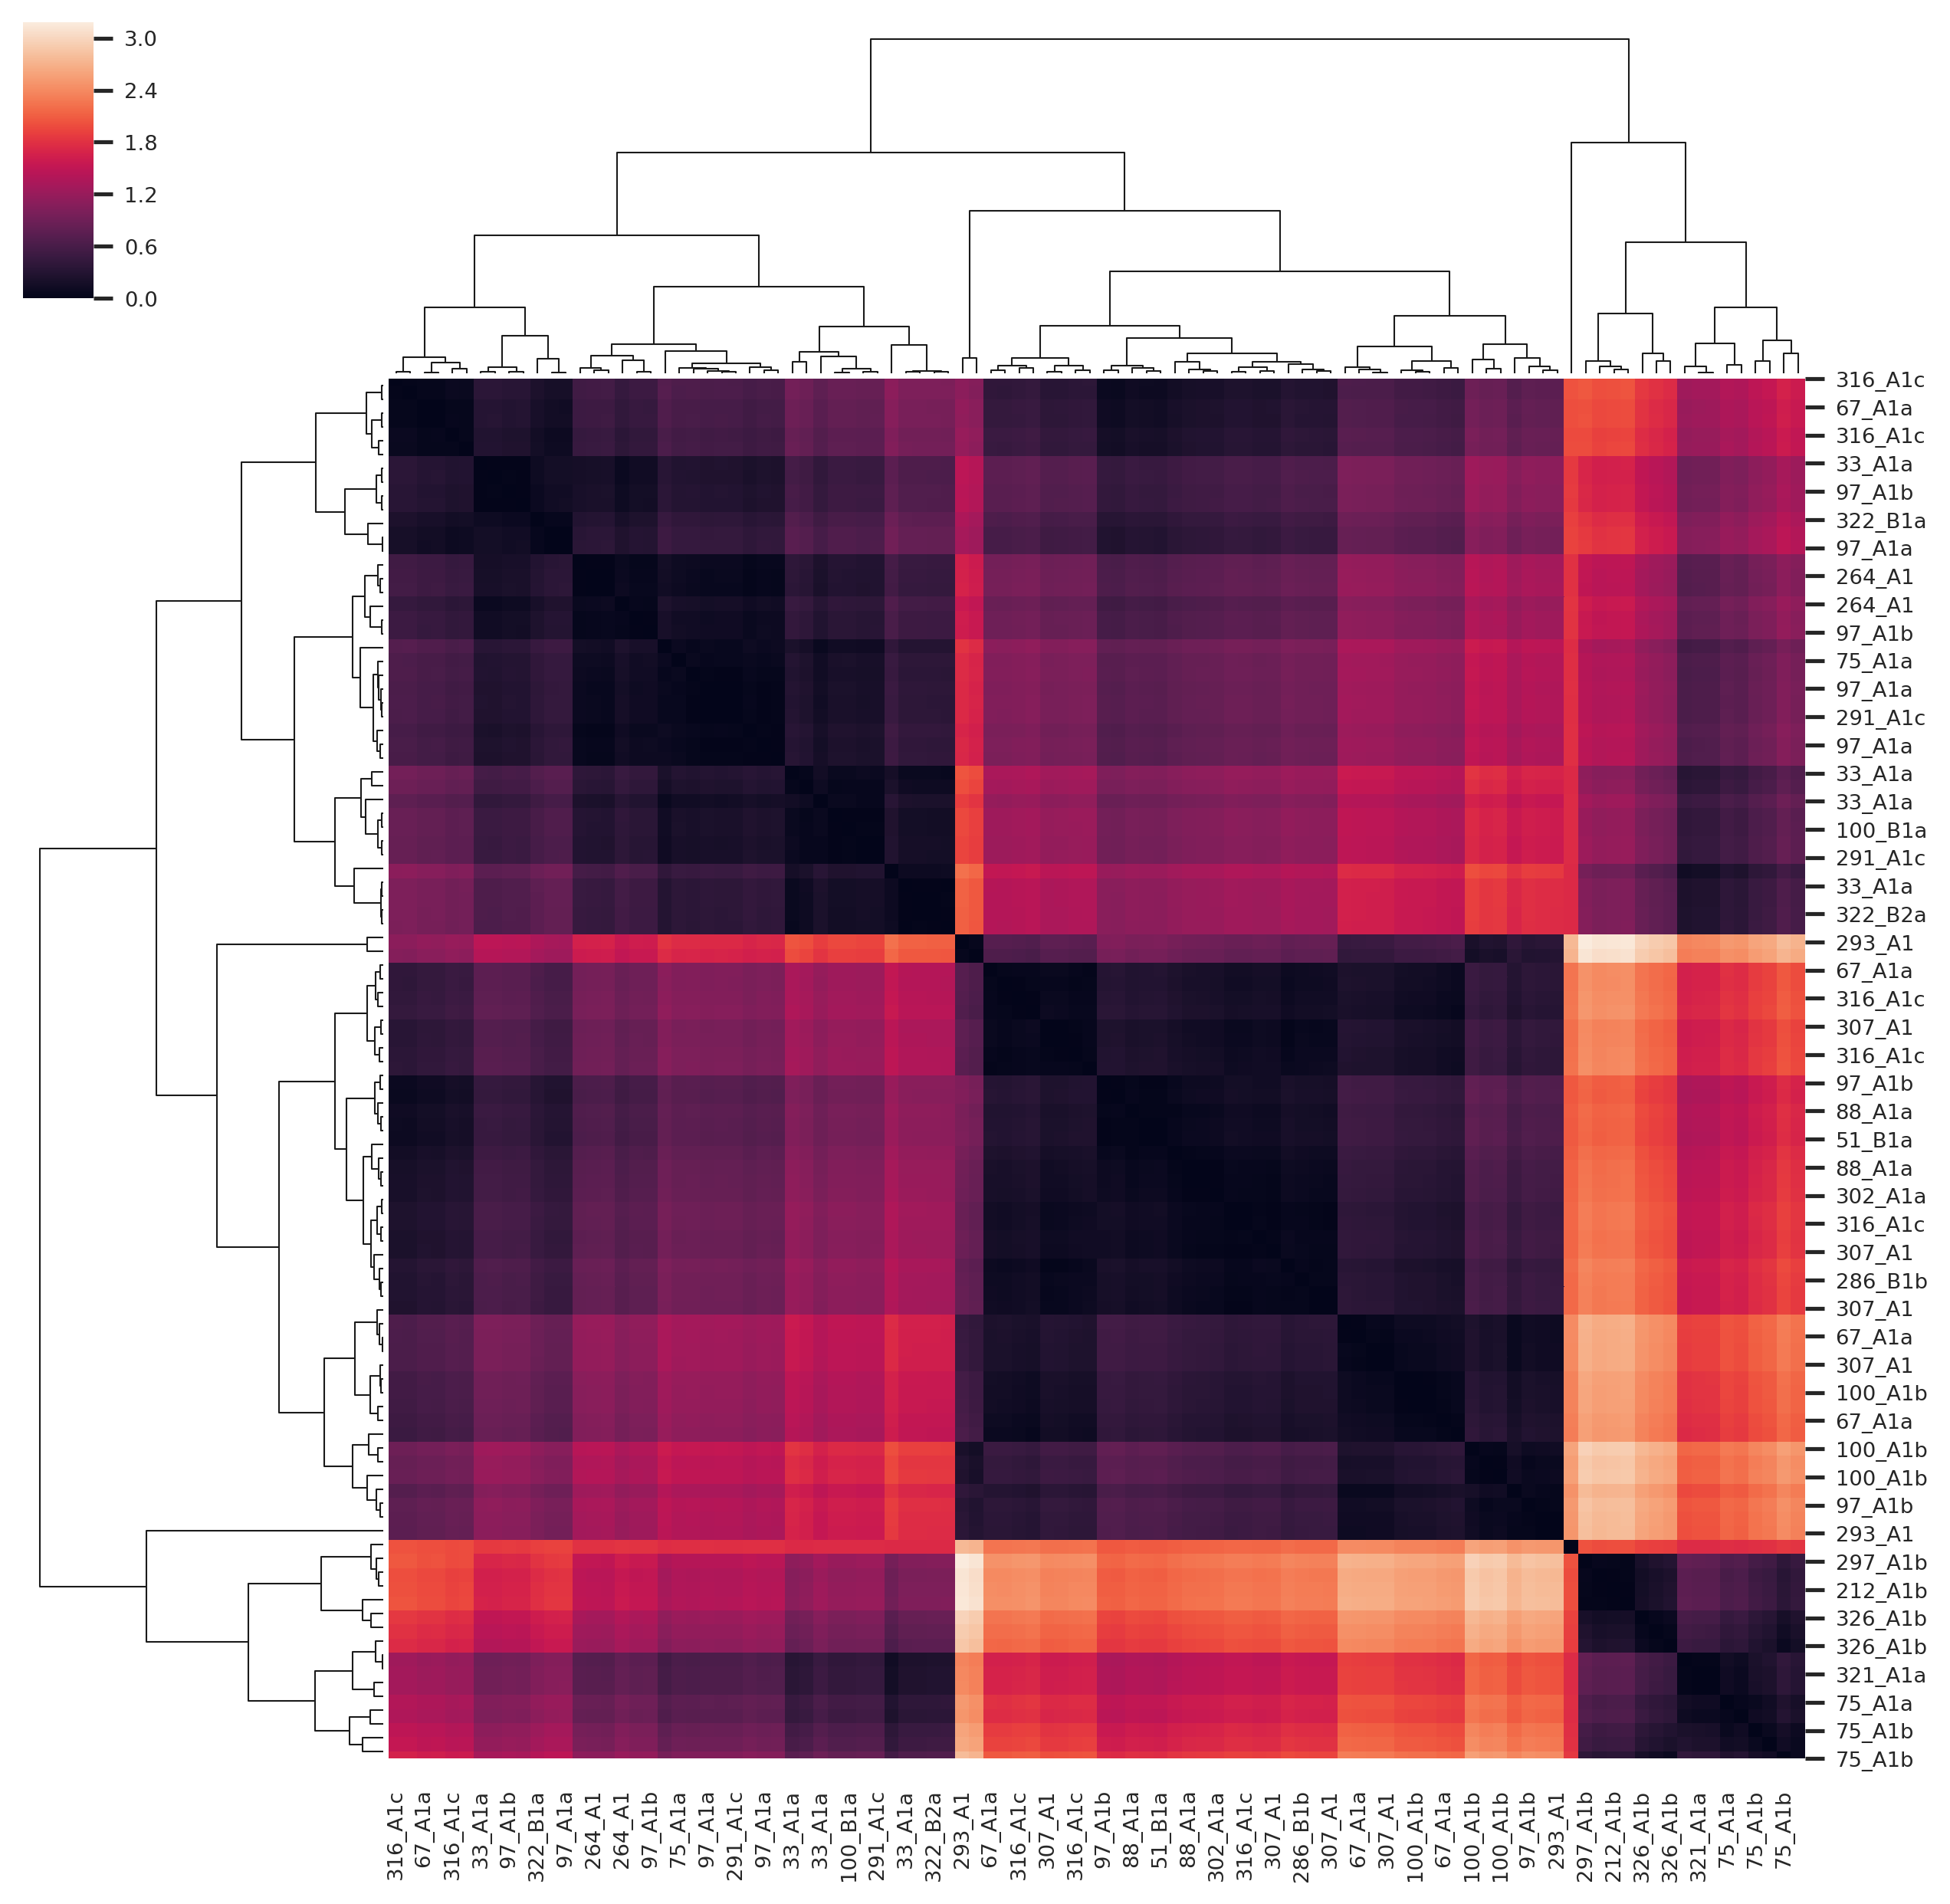

In [11]:
import seaborn as sns, pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi']=300
sns.set(font_scale=0.6)
from sklearn.metrics import pairwise_distances
ids=[x.id for x in graph_datasets['graph_dataset']][:n_shapes]
sns.clustermap(pd.DataFrame(pairwise_distances(X_train),columns=ids,index=ids))

In [12]:
plot_point_cloud(X_train)


In [13]:
ids[X_train[:,-1].argmax()]

'322_B2a'

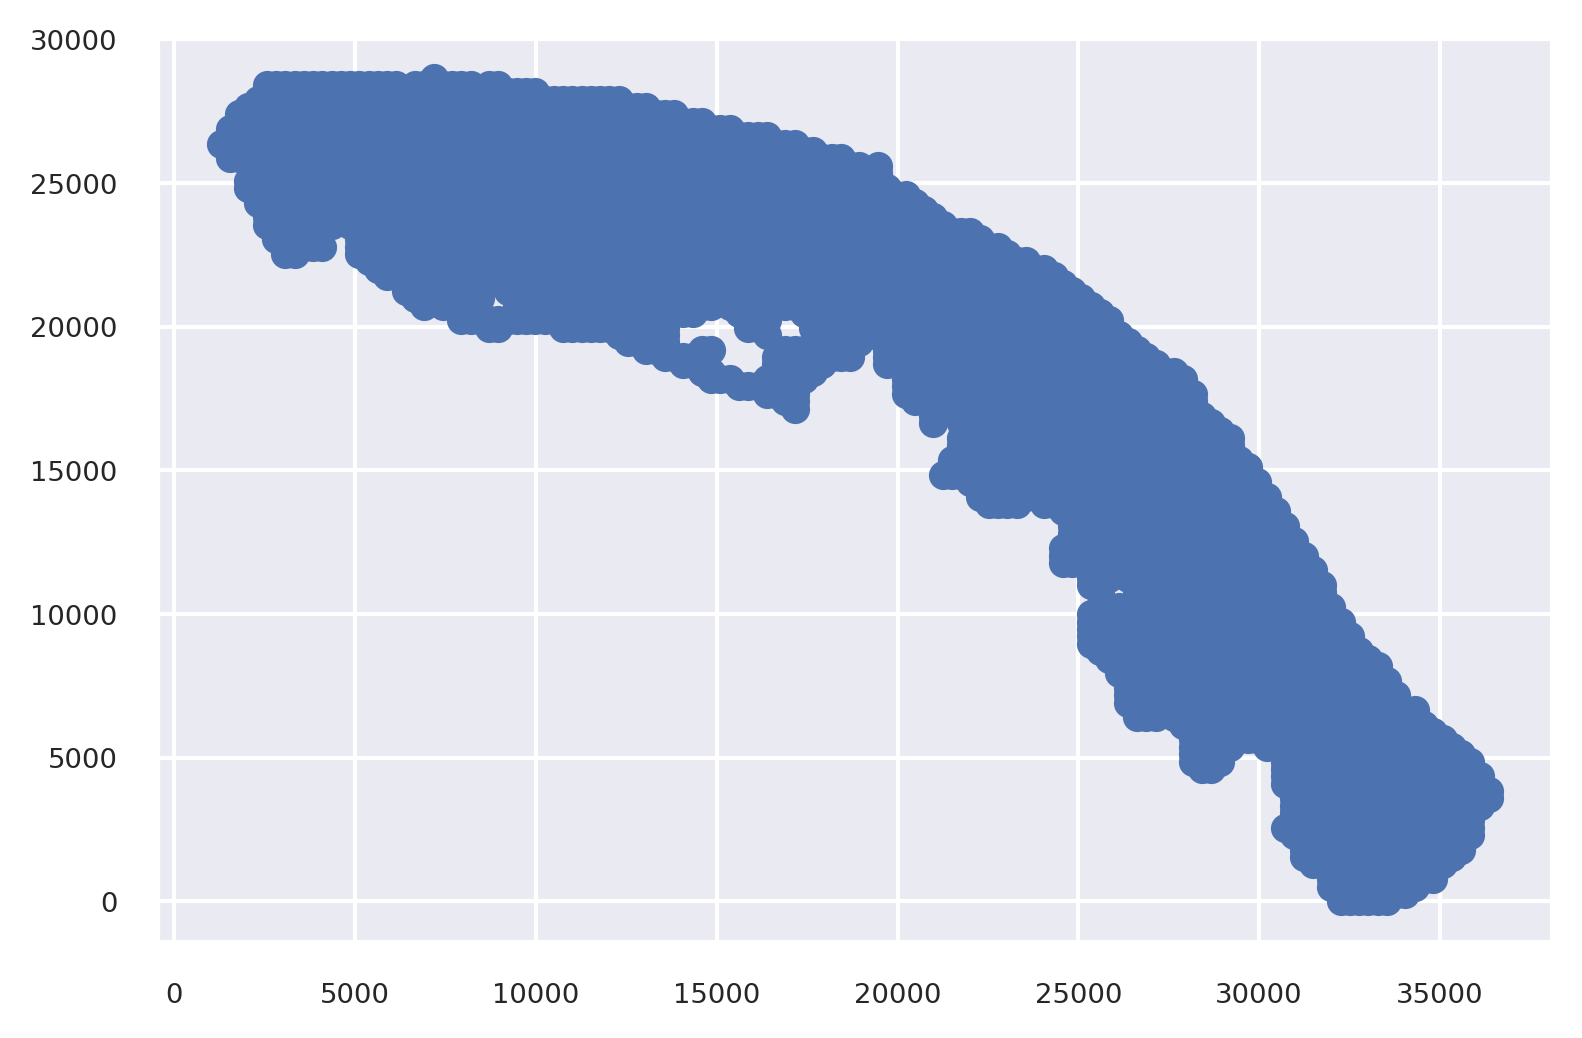

In [14]:
import matplotlib.pyplot as plt
plt.scatter(*X[X_train[:,-1].argmax()].T.tolist())

In [15]:
X_train

array([[ 7.39572161,  7.31904749, -0.        ],
       [ 7.4593389 ,  7.38081286, -0.        ],
       [ 7.50104022,  7.42892266, -0.        ],
       [ 7.4506608 ,  7.37422226, -0.        ],
       [ 7.85858206,  7.75831824, -0.        ],
       [ 8.19450551,  8.11789962, -0.        ],
       [ 8.30100641,  8.24230984, -0.        ],
       [ 8.24433405,  8.18152644, -0.        ],
       [ 8.16076059,  8.0485134 , -0.        ],
       [ 7.98104976,  7.90893758, -0.        ],
       [ 7.90946163,  7.84040423, -0.        ],
       [ 7.84893373,  7.77171131, -0.        ],
       [ 7.97108575,  7.89973593, -0.        ],
       [ 7.73718008,  7.64298215, -0.        ],
       [ 7.45587669,  7.3295586 , -0.        ],
       [ 7.24351297,  7.14107162, -0.        ],
       [ 7.34918205,  7.19192982, -0.        ],
       [ 7.17778242,  7.03406682, -0.        ],
       [ 7.62552112,  7.54197163, -0.        ],
       [ 8.04037362,  7.95373589, -0.        ],
       [ 8.02845516,  7.94621368, -0.   

In [16]:
from sklearn.cluster import AgglomerativeClustering
c=AgglomerativeClustering(n_clusters=14).fit_predict(X_train)

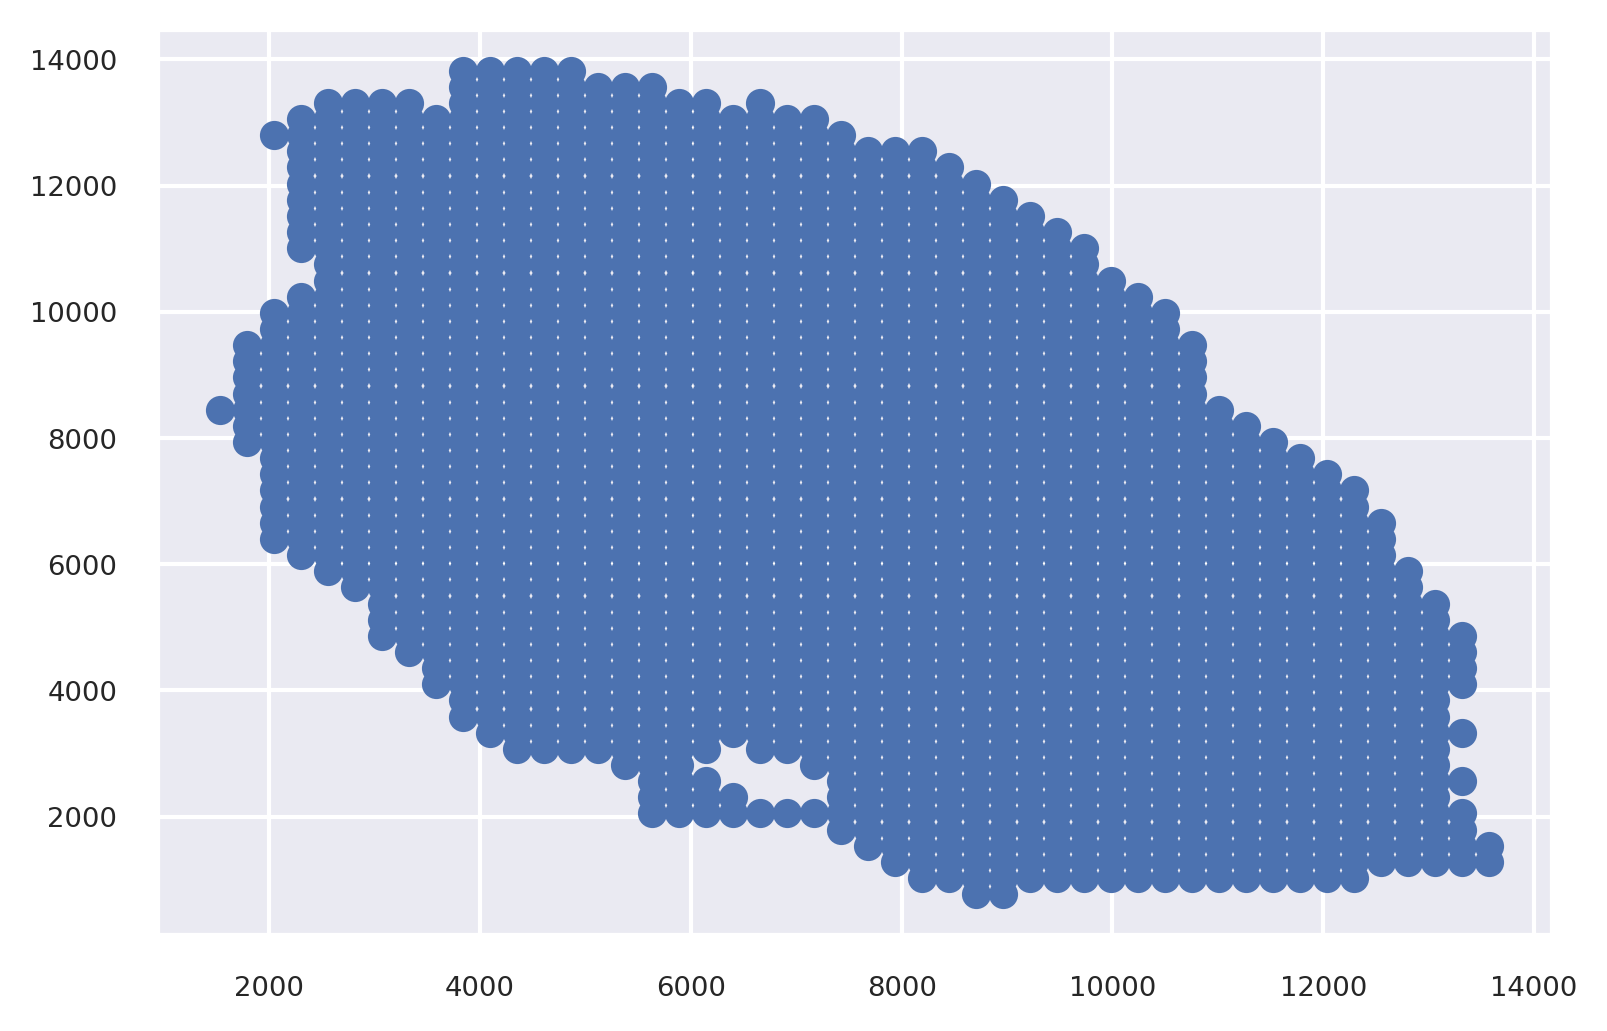

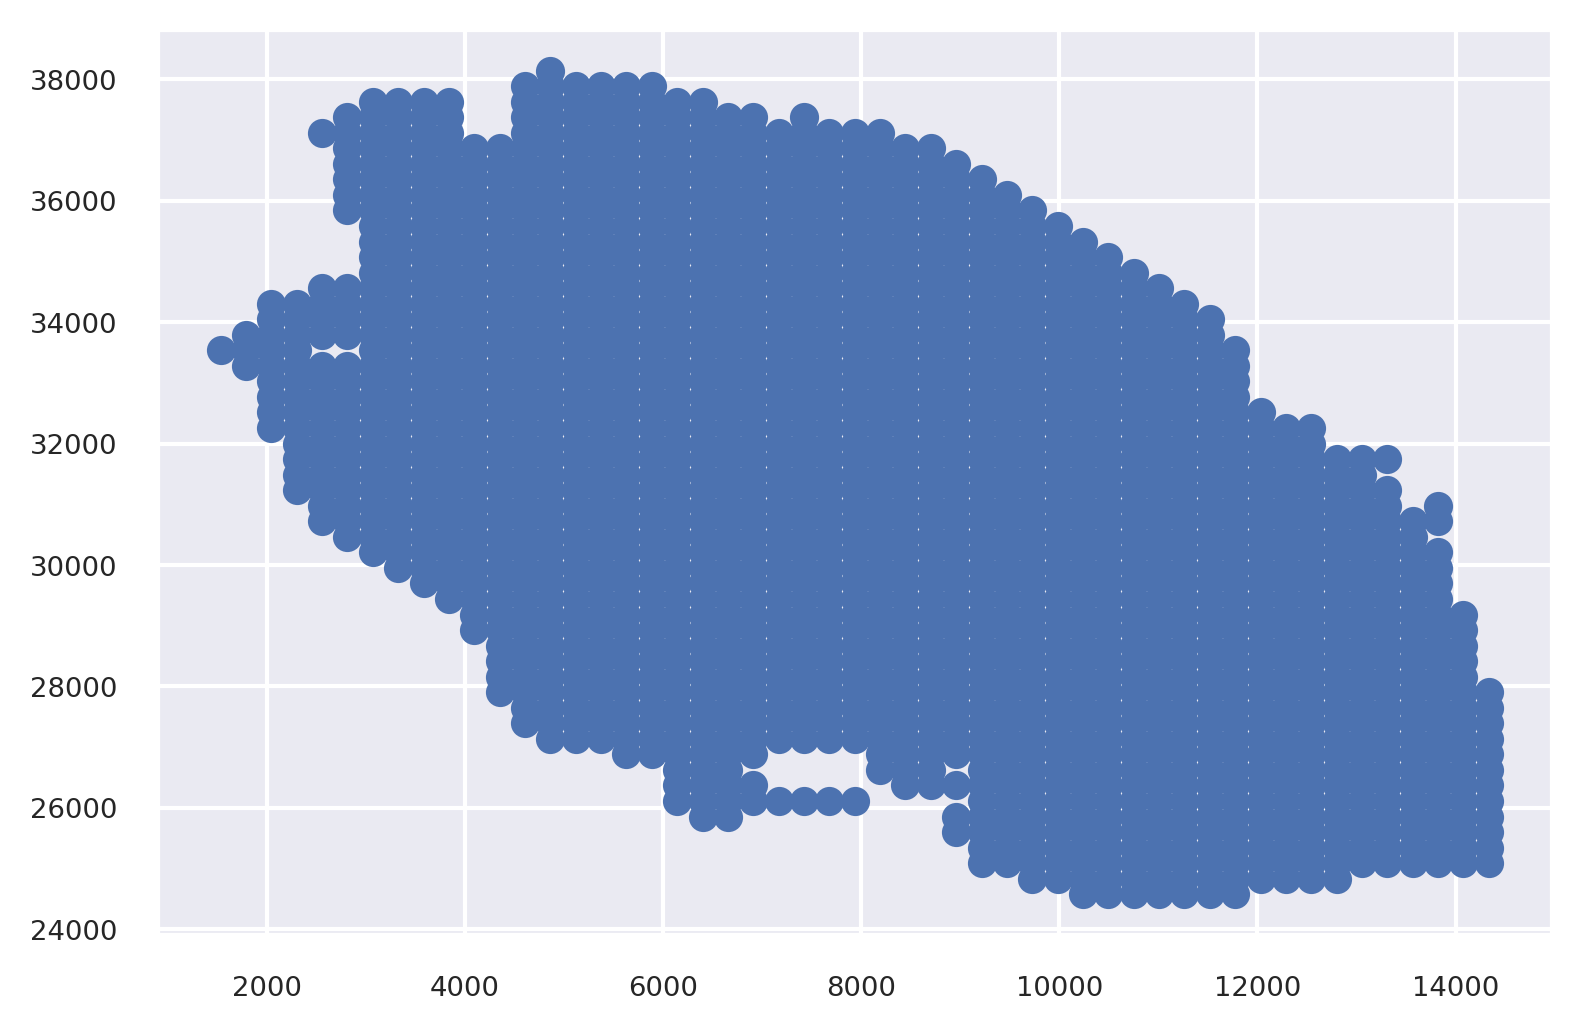

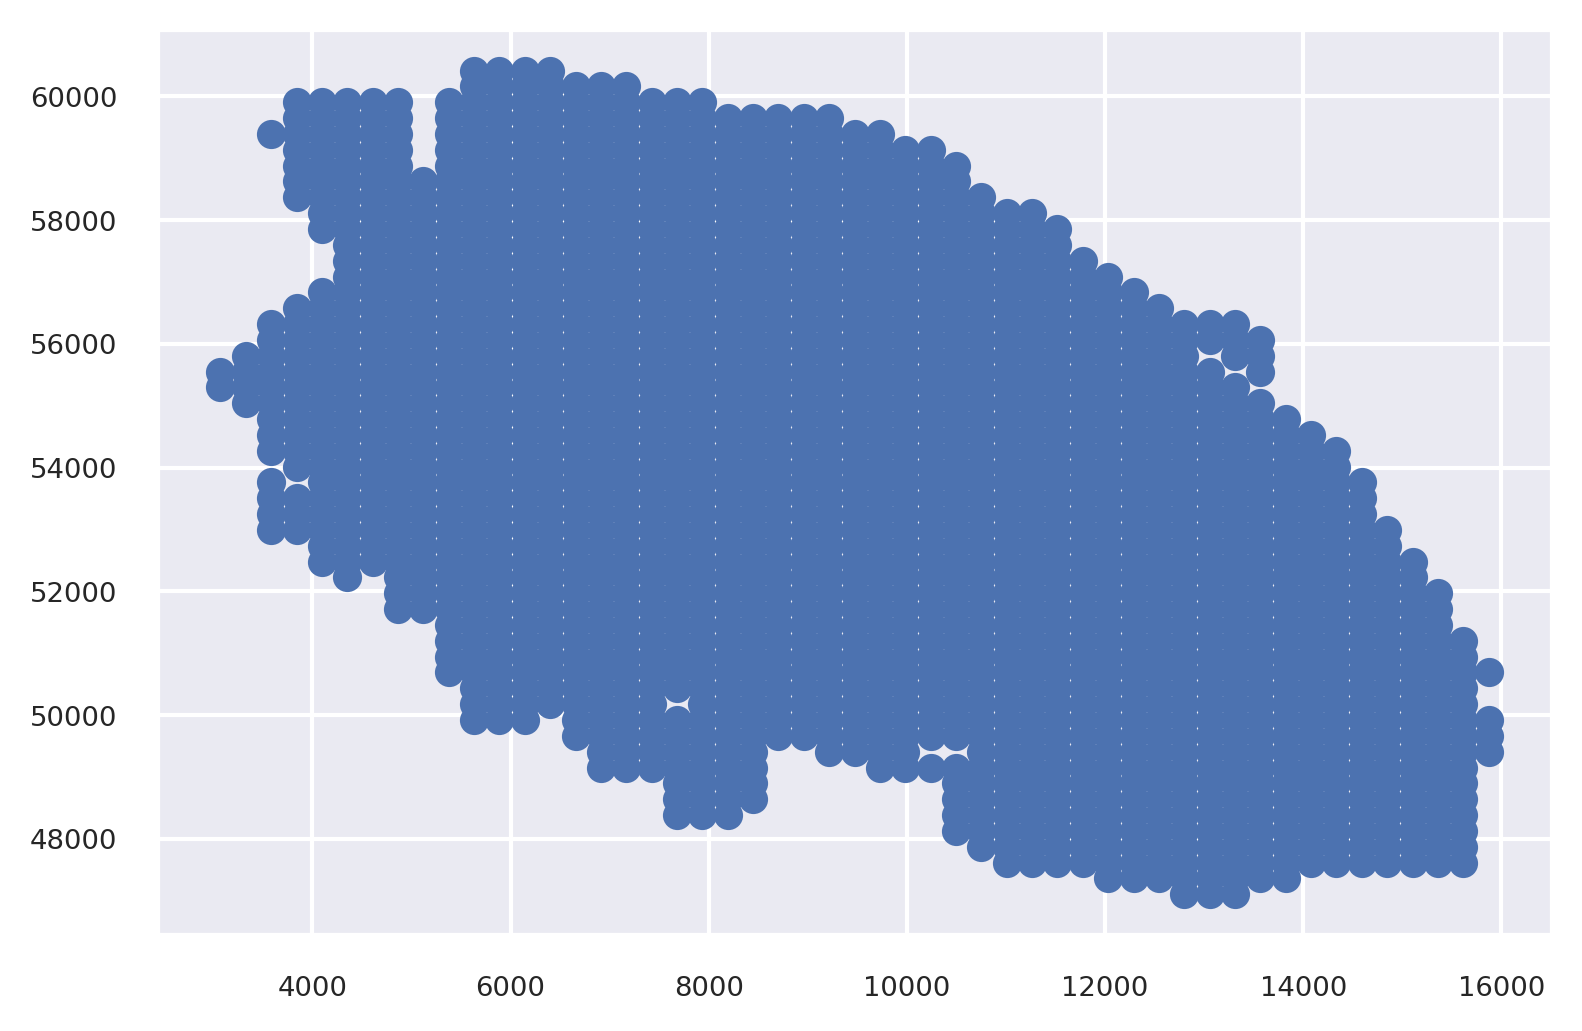

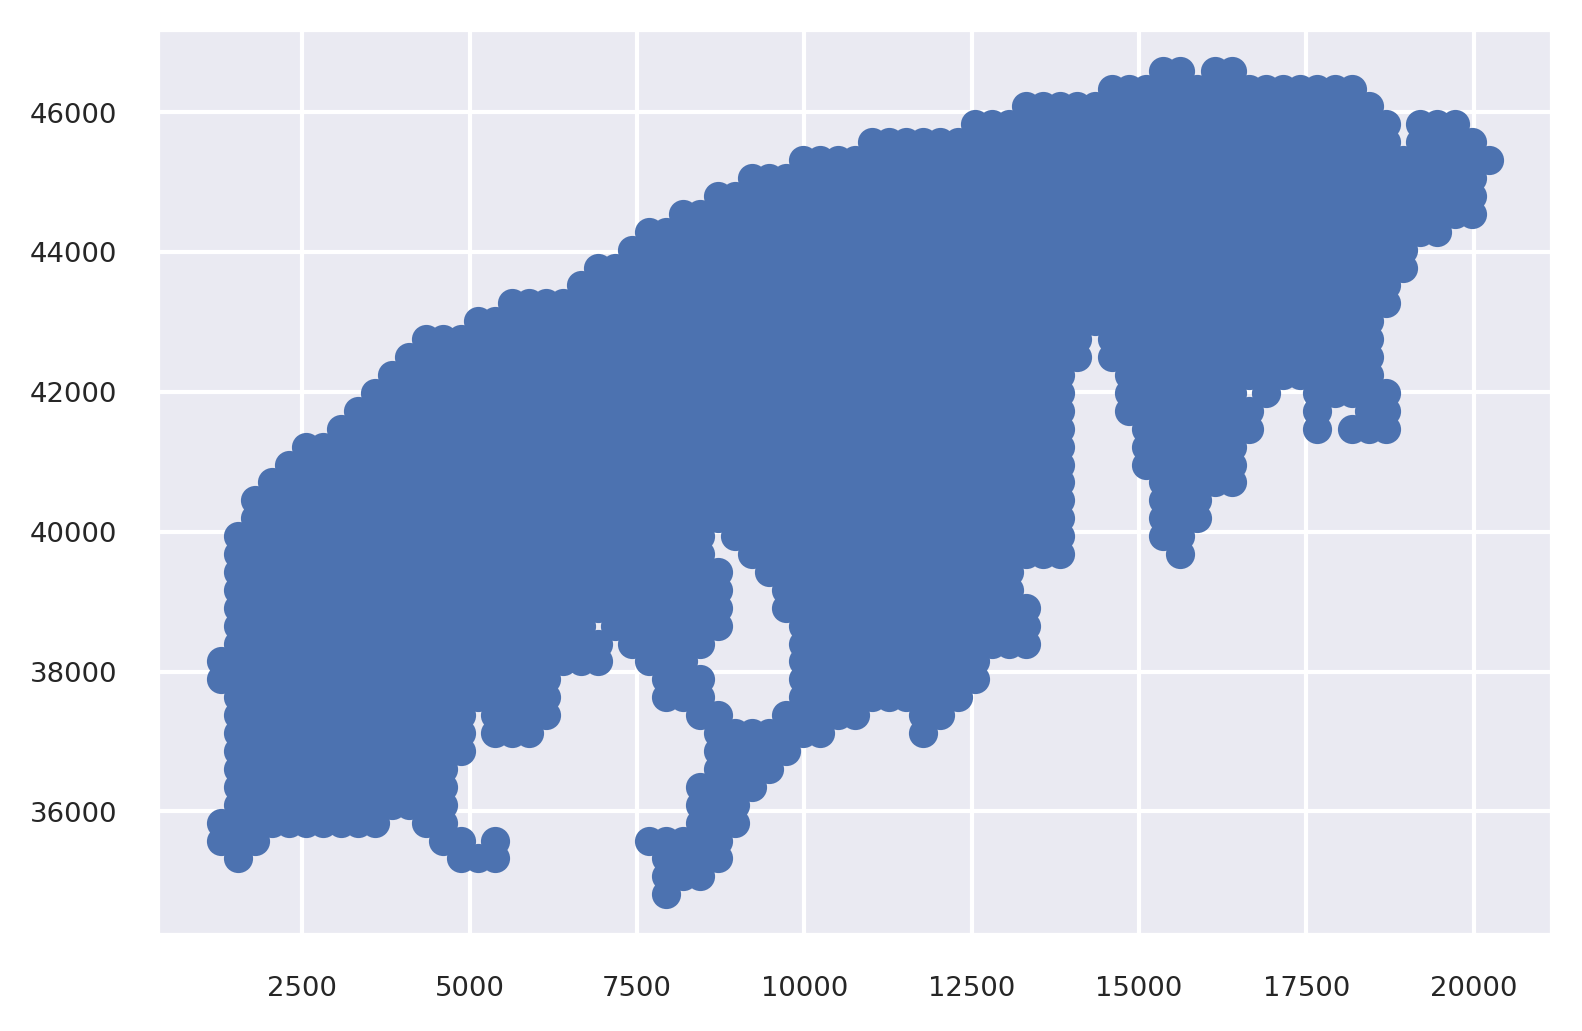

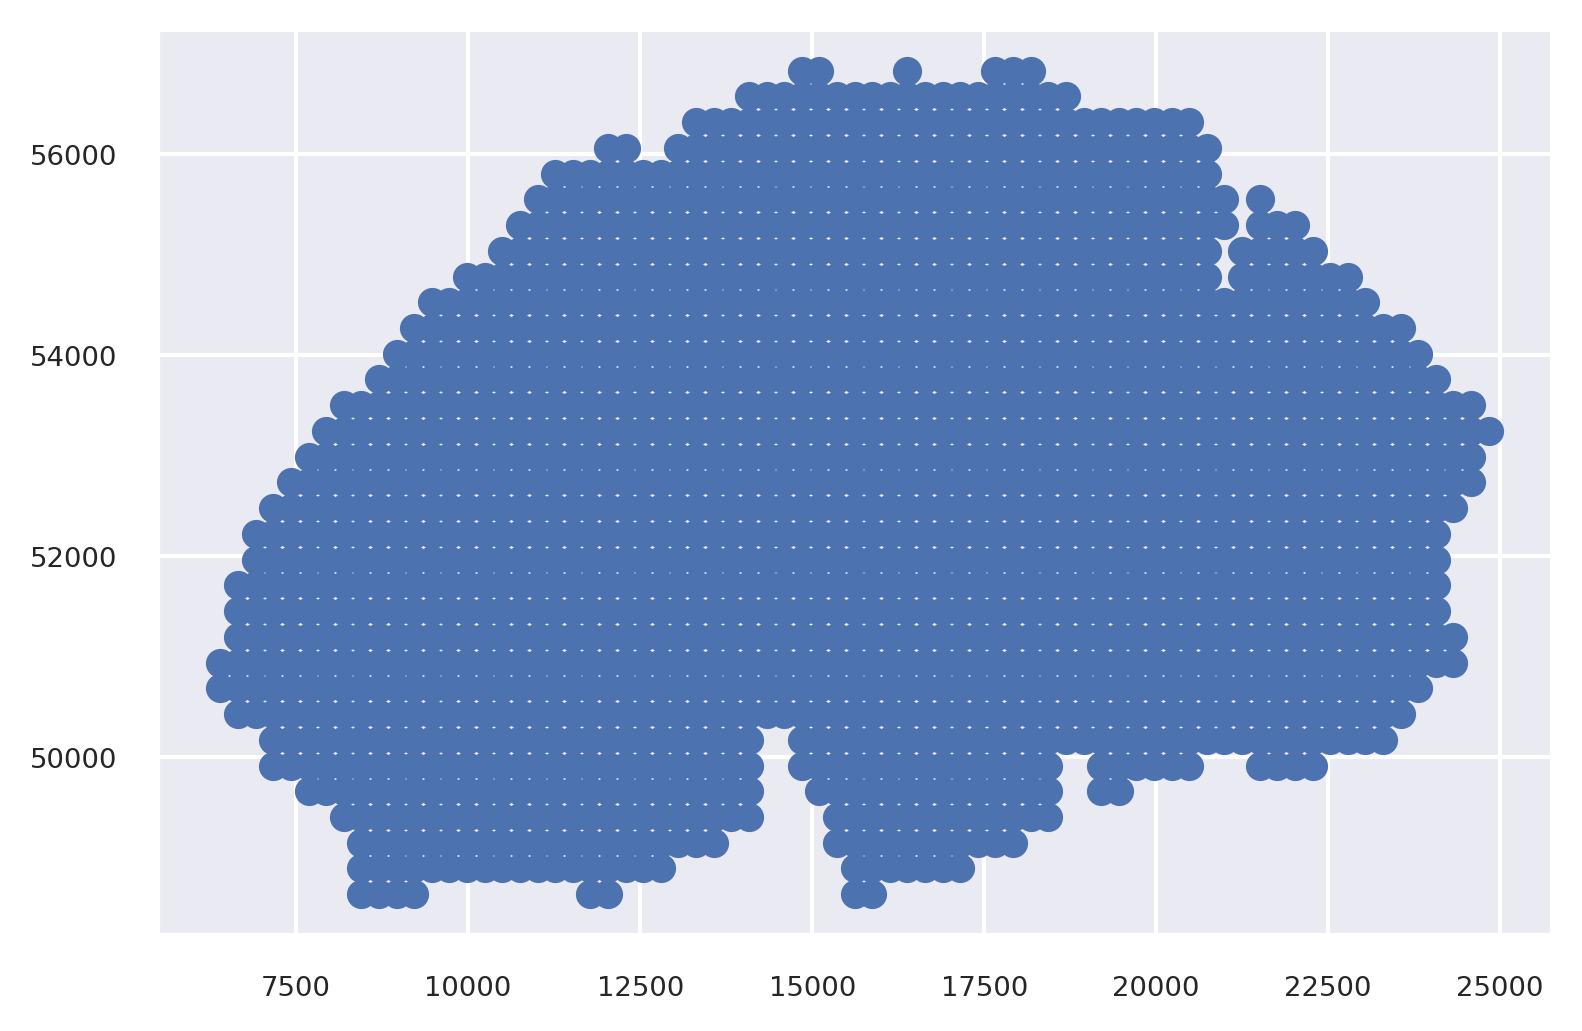

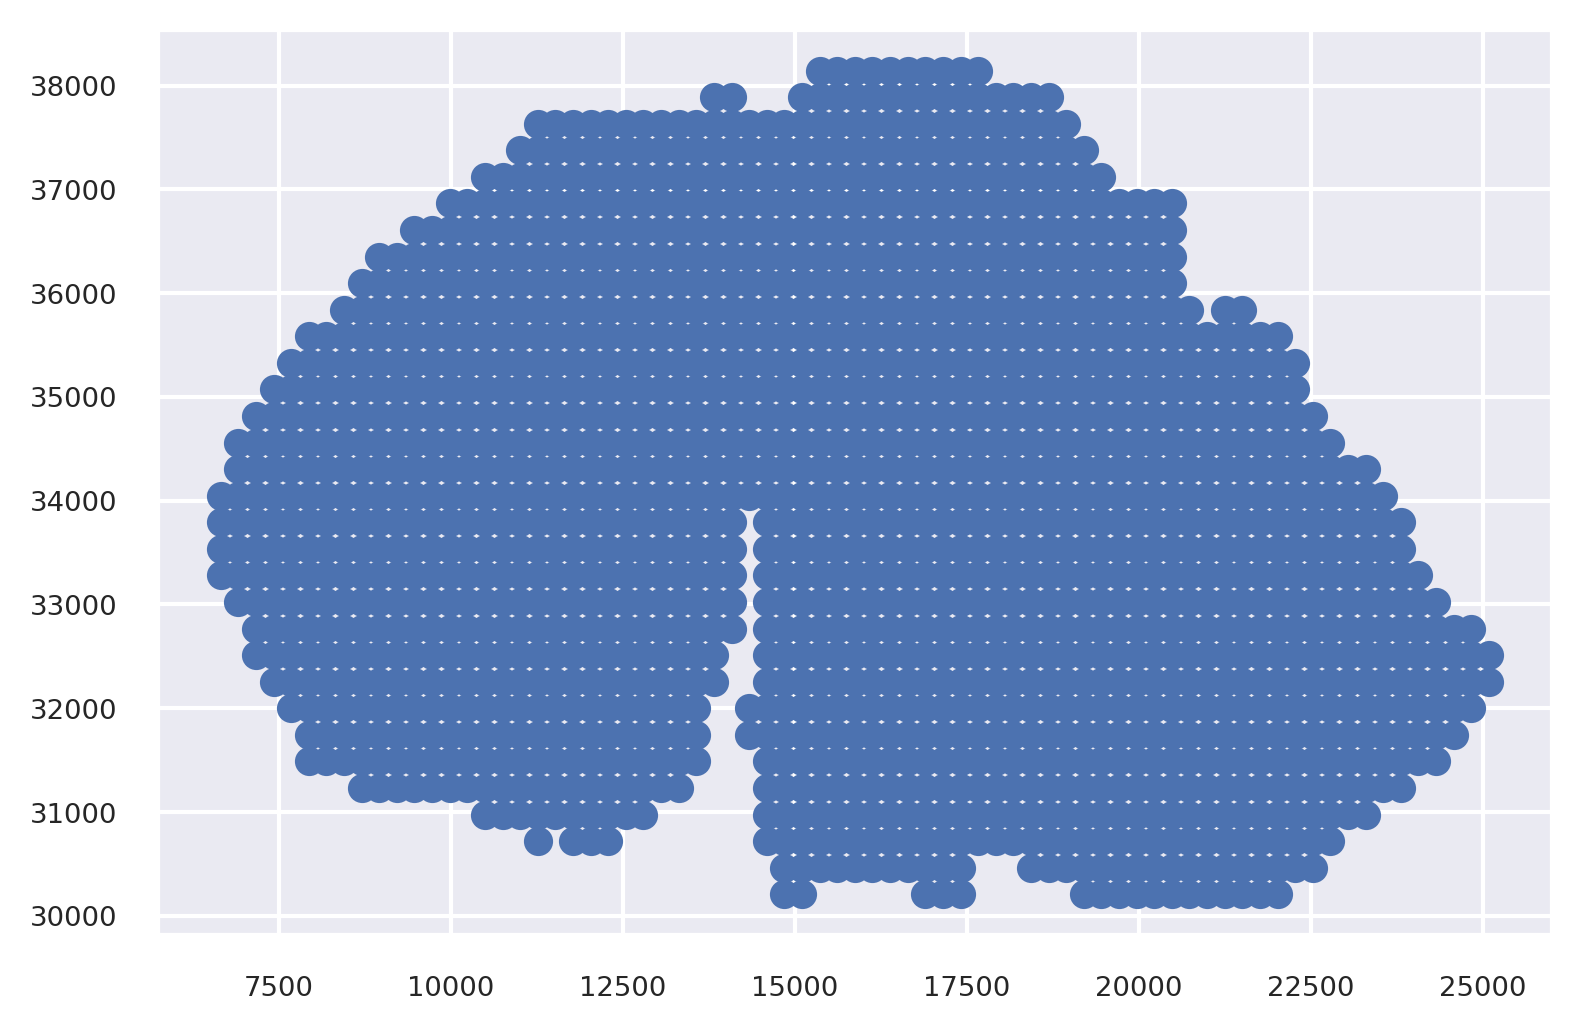

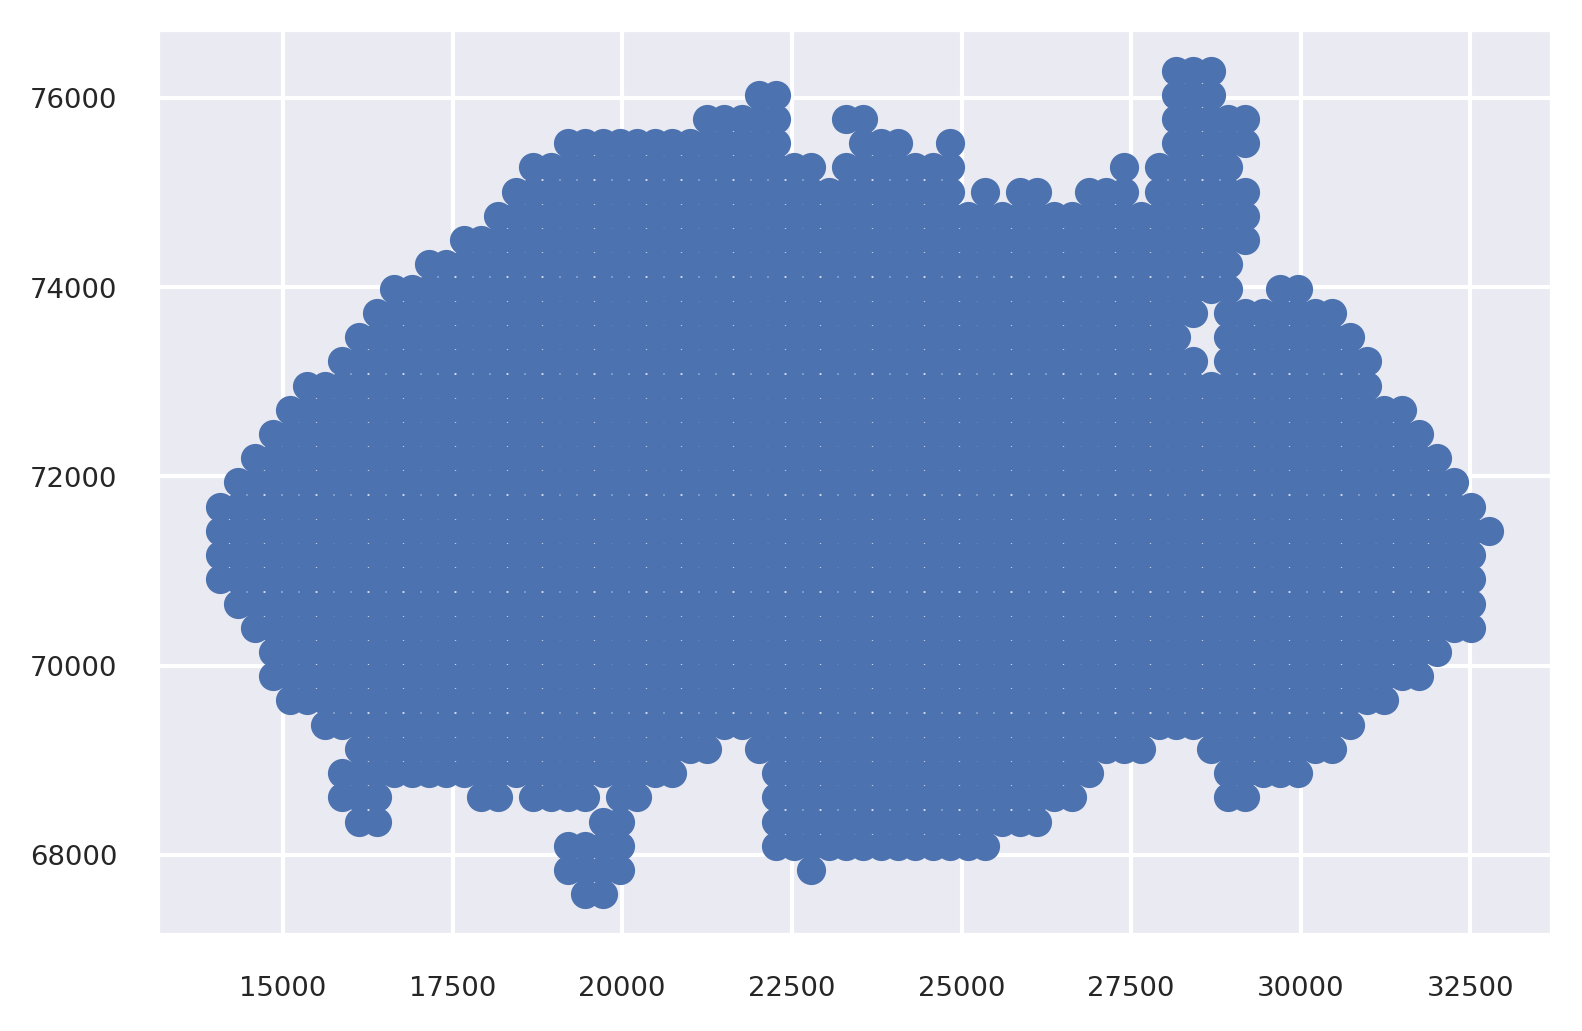

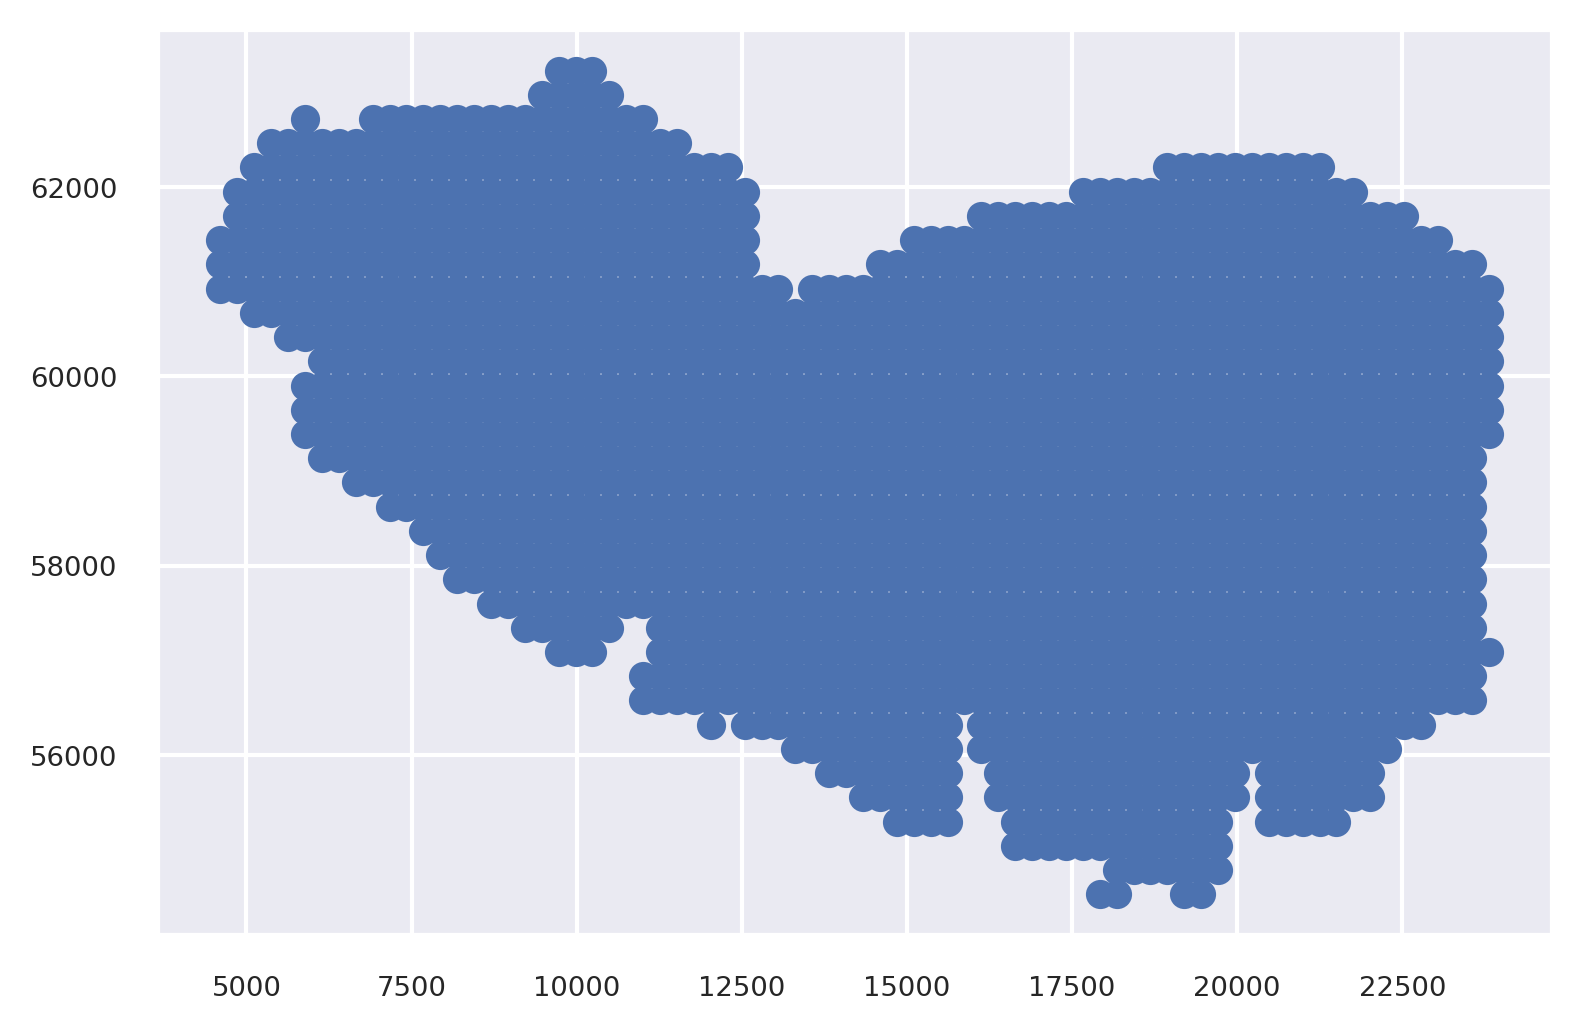

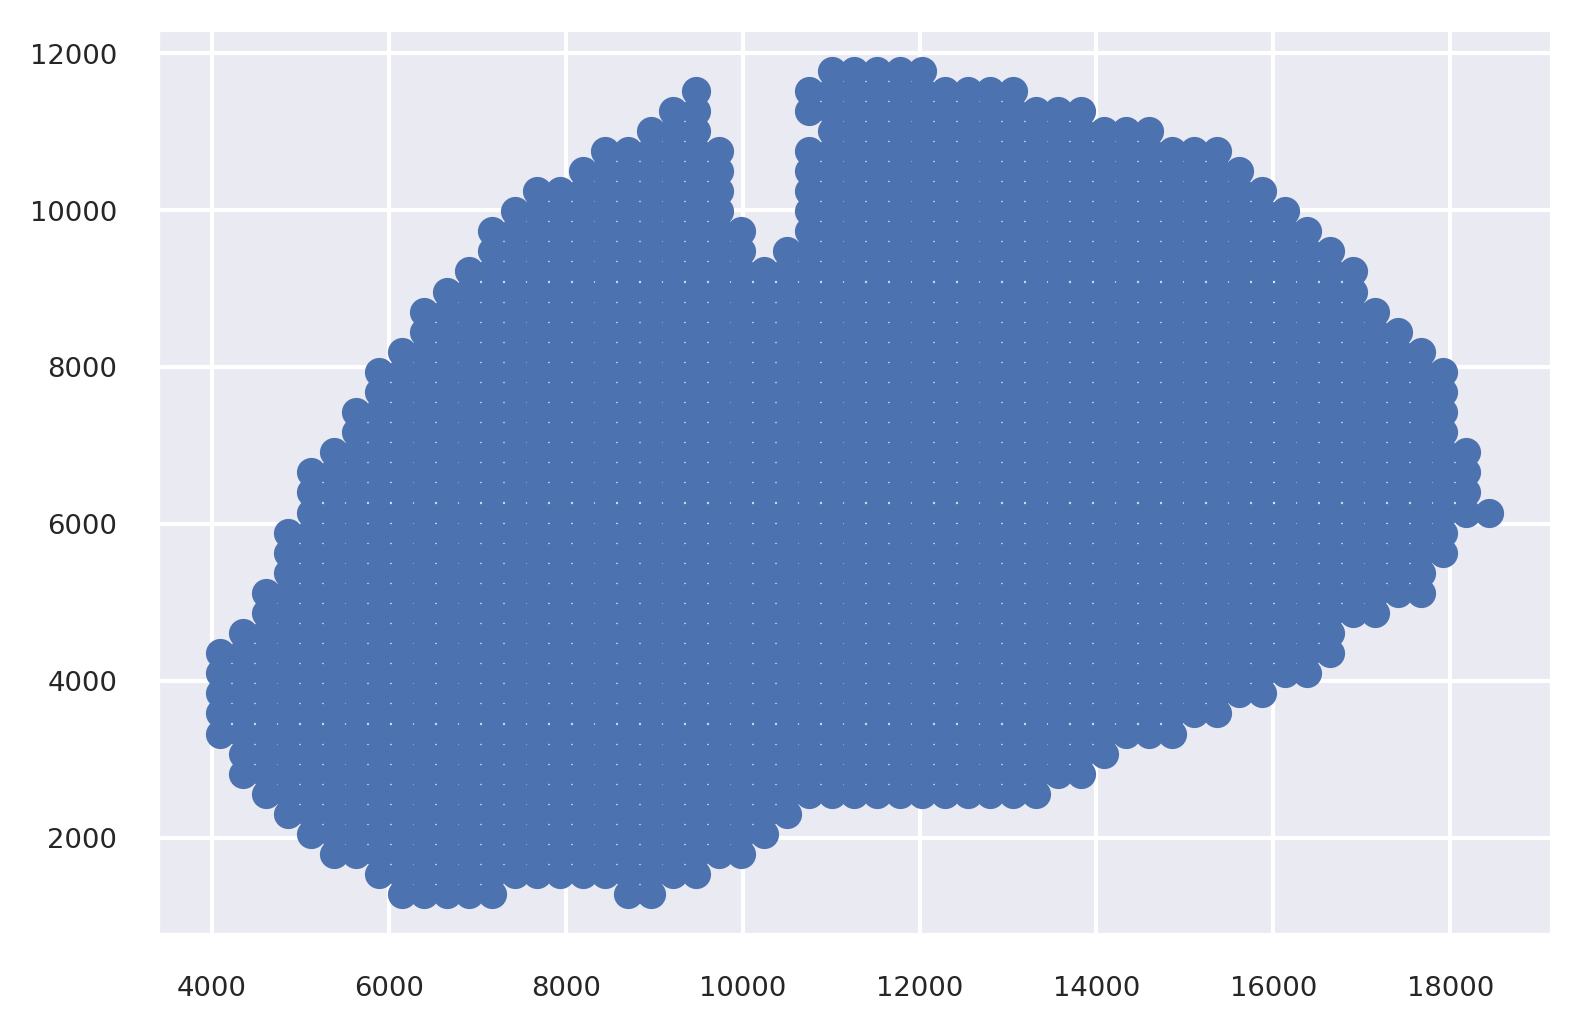

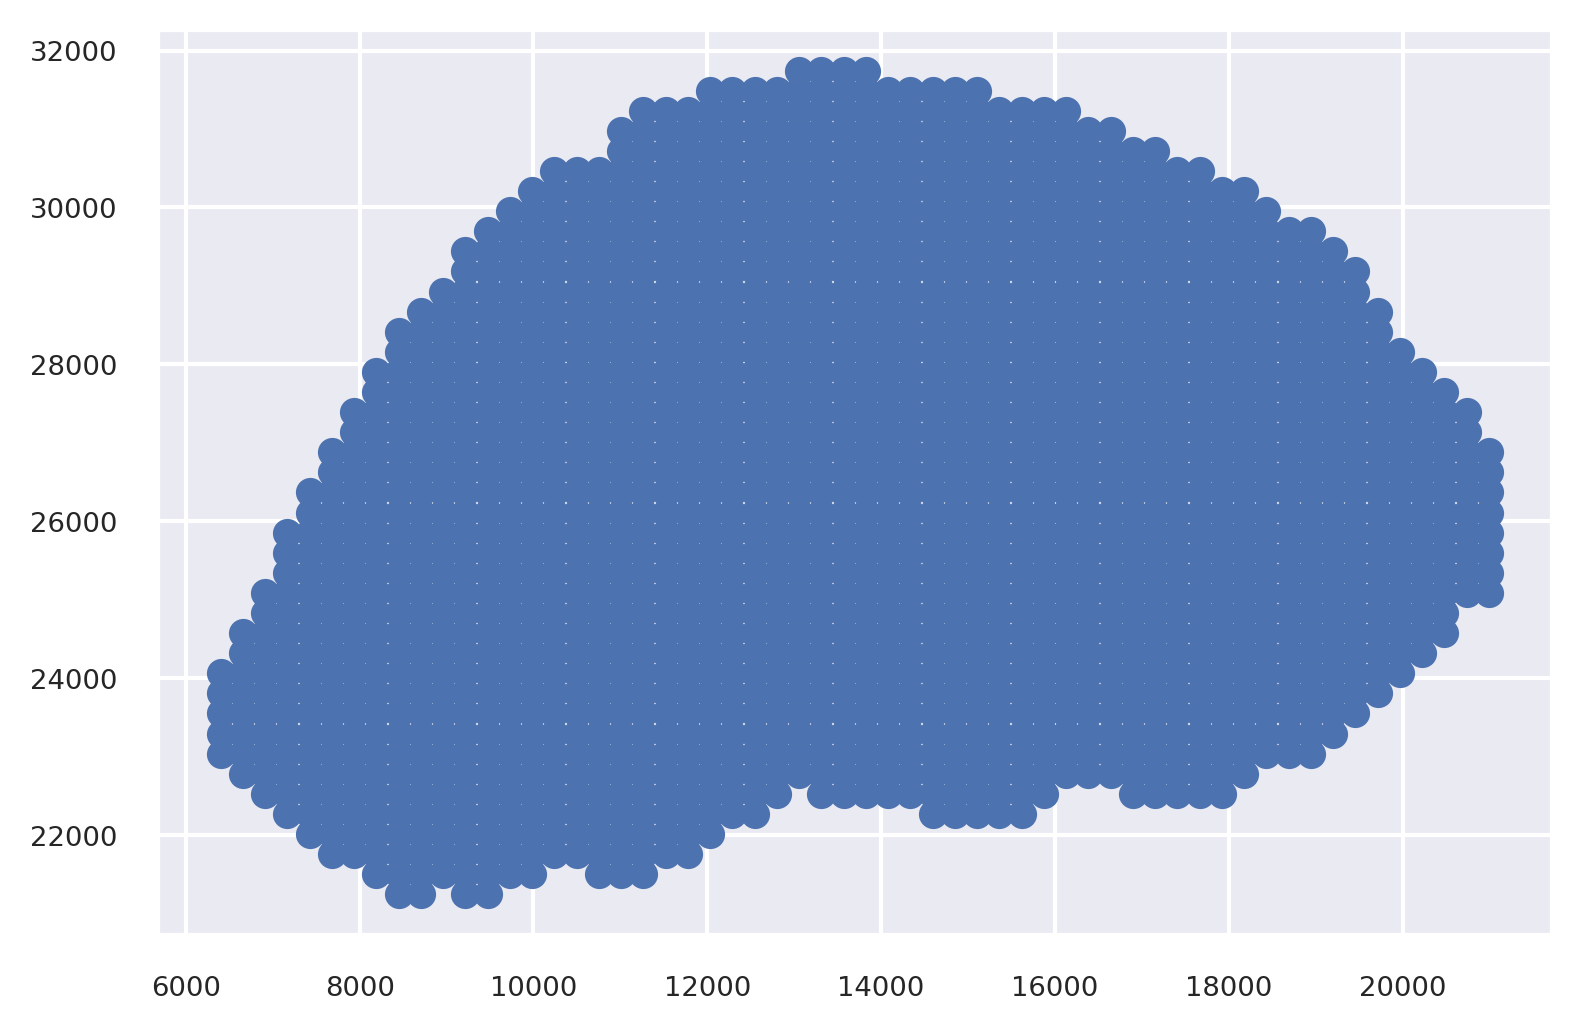

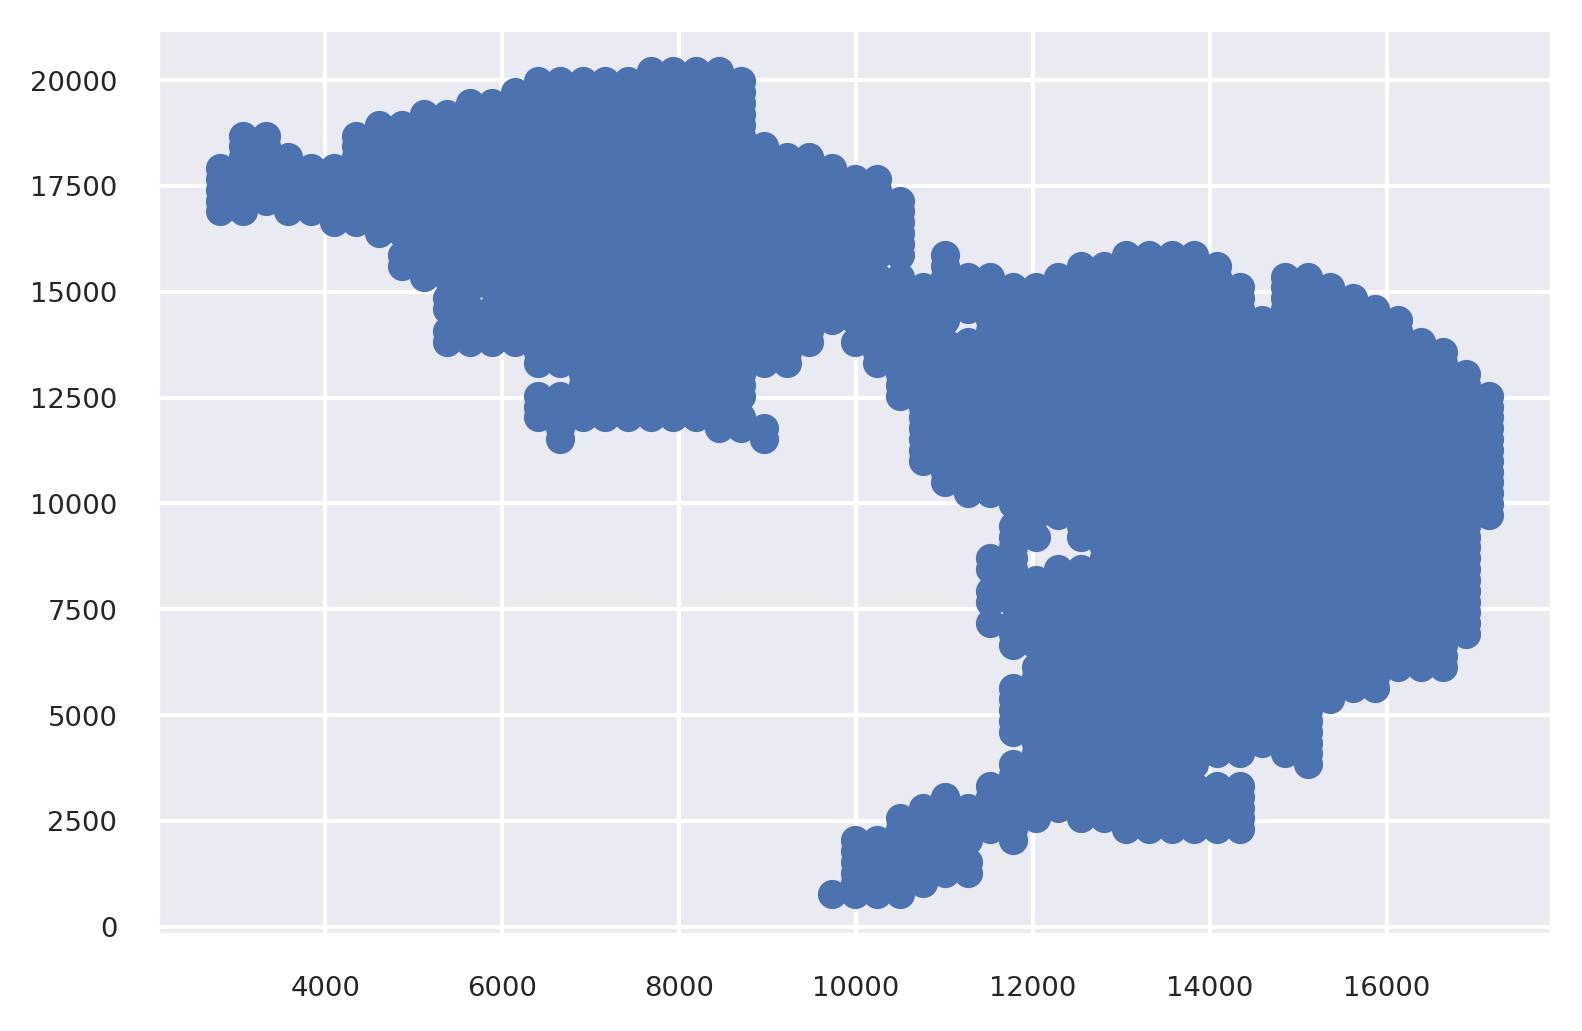

In [17]:
for i in np.where(c==8)[0]:
    plt.figure()
    plt.scatter(*X[i].T.tolist())
